# Project 2

It is October 2018. The squirrels in Central Park are running into a problem and we need your help.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled preprocessor and final model along with this notebook.

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

Frame the Problem and Look at the Big Picture
========================

1. **Define the objective in business terms.**
   - The objective is to develop a predictive model to identify potentially sick squirrels in Central Park from reported sightings, enabling the client to respond quickly to disease risks. The model should help prevent squirrel disease spread, preserving this critical ecological component by prioritizing intervention for identified sick individuals.

2. **How will your solution be used?**
   - The model will provide online predictions, flagging sightings that likely indicate sickness based on specific patterns. These flagged sightings will trigger response actions, helping the client or park rangers identify which squirrels need attention, ideally catching every sick squirrel to mitigate any spread.

3. **What are the current solutions/workarounds (if any)?**
   - Currently, sightings are reported by people, but there's no predictive mechanism to evaluate the health status of observed squirrels. Without this model, decisions might rely on manual assessments or sporadic checks, which may not consistently or accurately detect health risks.

4. **How should you frame this problem (supervised/unsupervised, online/offline, …)?**
   - This is a **supervised, binary classification** problem. We aim to classify sightings as "sick" or "not sick," based on labeled data or inferred from characteristics. Since the client needs ongoing predictions, an **online** learning model would be appropriate if data is continuously fed.

5. **How should performance be measured? Is the performance measure aligned with the business objective?**
   - **Recall** (sensitivity) should be prioritized, as the client aims to catch every sick squirrel, even at the cost of some false positives. High recall aligns with the business goal of minimizing undetected cases, thereby controlling disease spread.

6. **What would be the minimum performance needed to reach the business objective?**
   - A minimum recall threshold of perhaps **90-95%** could be necessary, given the critical nature of detecting all potential sickness cases. The model may tolerate some level of false positives, but it should rarely miss any cases of sick squirrels.

7. **What are comparable problems? Can you reuse experience or tools?**
   - This problem is similar to **medical screening** or **wildlife monitoring** models, where high recall is critical to prevent issues like disease outbreaks. Techniques used in health diagnostics or ecological monitoring, like anomaly detection, high-recall classifiers, and time-series analysis, might be applicable.

8. **Is human expertise available?**
   - Not as of currently.

9. **How would you solve the problem manually?**
   - I would focus on specific symptoms and actions from the squirrels. I would also focus on working with weather data as weather could play a part in squirrel sickness.

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.**
    - **Assumptions**:
      - The sightings data includes identifiable indicators of sickness.


Get the Data
=======================================================================

1. **List the data you need and how much you need.** 
    - We need data to predict either sick, or not sick. To do that we need New York Central Park squirrel census from 2018. We would also need label data to know whether the squirrels are sick or not. We would also need weather data to identify any correlation. 
2. **Find and document where you can get that data:** 
    - From the client the diseased squirrels dataset. 
    - `https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data`
    - `https://www.wunderground.com/history/monthly/us/ny/new-york-city/KNYC/date/2018-10`
3. **Get access authorizations:** 
    - Done
4. **Create a workspace (with enough storage space):**
    - This notebook.
5. **Get the data:** 
    - Got the data
6. **Convert the data to a format you can easily manipulate (without changing the data itself):** 
    - Done, it's a CSV.
7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** 
    - Done
8. **Check the size and type of data (time series, geographical, …):** 
    - <mark>TODO</mark>
9. **Sample a test set, put it aside, and never look at it (no data snooping!):** 
    - <mark>TODO</mark> 

In [280]:
def merge_data():
    """
    Prepares and merges two datasets: a diseased squirrel dataset and the Central Park squirrel census data.
    
    - Reads the diseased squirrel data from 'diseased_squirrels.csv' with a single column labeled 'Unique Squirrel ID'.
    - Reads the Central Park squirrel census data from '2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241104.csv'.
    - Checks if the columns 'Unique Squirrel ID' exist in both datasets.
    - Creates a 'Diseased' column in the census data (df2) by checking if each squirrel in df2's 'Unique Squirrel ID' column
      is present in the diseased squirrel dataset (df1).
    - Saves the updated census data with the 'Diseased' column to 'merged_data.csv'.
    
    Raises:
        KeyError: If 'Unique Squirrel ID' is not found in one of the dataframes.
    """
    # read data
    df1 = pd.read_csv('diseased_squirrels.csv', header=None, names=['Unique Squirrel ID'])
    df2 = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241104.csv')

    # check column names
    print(df1.columns)
    print(df2.columns)

    # ensure column names match
    if 'Unique Squirrel ID' in df1.columns and 'Unique Squirrel ID' in df2.columns:
        # create a 'Diseased' column in df2
        df2['Diseased'] = df2['Unique Squirrel ID'].isin(df1['Unique Squirrel ID'])
    else:
        raise KeyError("Column 'Unique Squirrel ID' not found in one of the dataframes")
        
    # save data
    df2.to_csv('merged_data.csv', index=False)

merge_data()

def merge_squirrel_weather_data(squirrel_data, weather):
    """
    Merges squirrel sighting data with weather data based on the date.
    
    Parameters:
        squirrel_data (DataFrame): DataFrame containing squirrel sightings data with a 'Date' column.
        weather (DataFrame): DataFrame containing weather data with a 'Time' column in MM-DD format.
    
    - Converts the 'Date' column in the squirrel sightings data to a datetime format.
    - Converts the 'Time' column in the weather data to a datetime format and applies the year 2018.
    - Merges the squirrel data and weather data on the 'Date' column with a left join.
    
    Returns:
        DataFrame: A combined DataFrame with squirrel sightings and corresponding weather data.
    """
    # Convert the Date column in squirrel_data to datetime format
    squirrel_data['Date'] = pd.to_datetime(squirrel_data['Date'], format='%m%d%Y')

    # Convert the Time column in weather to datetime format
    weather['Date'] = pd.to_datetime(weather['Time'], format='%d').apply(lambda x: x.replace(month=10, year=2018))

    # Merge the dataframes on the Date column
    combined_data = pd.merge(squirrel_data, weather, on='Date', how='left')

    # Display the first few rows of the combined dataframe
    return combined_data

squirrel_data = pd.read_csv('merged_data.csv')
weather = pd.read_csv('October_weather_data.csv')

data = merge_squirrel_weather_data(squirrel_data, weather)



class SingleColumnBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, positive_value):
        self.column = column
        self.positive_value = positive_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binary_feature = np.where(X[self.column] == self.positive_value, 1, 0)
        return pd.DataFrame(binary_feature, columns=[f"{self.column}_binary"])

    # Add get_feature_names_out for compatibility with pipelines
    def get_feature_names_out(self, input_features=None):
        return [f"{self.column}_binary"]
    


class HighlightFurColorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.valid_colors = ['Black', 'White', 'Gray', 'Cinnamon']
        
    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformation

    def transform(self, X):
        X['Highlight Fur Color_Black'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'Black' in x else 0)
        X['Highlight Fur Color_White'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'White' in x else 0)
        X['Highlight Fur Color_Gray'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'Gray' in x else 0)
        X['Highlight Fur Color_Cinnamon'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'Cinnamon' in x else 0)
        
        # Drop the original 'Highlight Fur Color' column
        return X.drop(columns=['Highlight Fur Color'])

    def get_feature_names_out(self, input_features=None):
        # Return the names of the new binary columns including "Unknown"
        return [
            'Highlight Fur Color_Black',
            'Highlight Fur Color_White',
            'Highlight Fur Color_Gray',
            'Highlight Fur Color_Cinnamon',
            'Highlight Fur Color_Unknown'  # New column for unknown colors
        ]
    



class HotspotsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, eps=0.0002, min_samples=2):
        self.eps = eps
        self.min_samples = min_samples
        self.cluster_centers_ = None

    def fit(self, X, y=None):
        # Ensure that y is provided and contains the 'Diseased' information
        if y is None:
            raise ValueError("The target variable y with 'Diseased' information must be provided for HotspotsTransformer.")

        # Extract the coordinates of diseased squirrels
        diseased_coords = X[y == 1][['X', 'Y']].values

        # Use DBSCAN to identify clusters of diseased squirrels
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        diseased_clusters = dbscan.fit_predict(diseased_coords)

        # Get the coordinates of the cluster centers
        cluster_centers = []
        for cluster in set(diseased_clusters):
            if cluster != -1:  # Ignore noise points
                cluster_points = diseased_coords[diseased_clusters == cluster]
                cluster_center = cluster_points.mean(axis=0)
                cluster_centers.append(cluster_center)

        self.cluster_centers_ = np.array(cluster_centers)
        return self

    def transform(self, X):
        # Calculate the distance from each squirrel to the nearest diseased squirrel cluster
        if self.cluster_centers_ is not None and len(self.cluster_centers_) > 0:
            nbrs = NearestNeighbors(n_neighbors=1).fit(self.cluster_centers_)
            distances, _ = nbrs.kneighbors(X[['X', 'Y']].values)
            X = X.copy()  # Avoid modifying the original X
            X['hotspots'] = distances
            X['inverse_hotspot'] = 1 / distances
        else:
            X['hotspots'] = np.inf
            X['inverse_hotspot'] = 0

        return X

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns  # List of columns to drop

    def fit(self, X, y=None):
        # No fitting needed, simply return self
        return self

    def transform(self, X):
        # Drop the specified columns
        return X.drop(columns=self.columns, errors='ignore')
    
class BinaryBehaviorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, behavior_columns):
        # Initialize with the list of behavior columns
        self.behavior_columns = behavior_columns

    def fit(self, X, y=None):
        # No fitting is needed since we are just transforming the data
        return self

    def transform(self, X):
        # Convert the specified behavior columns to binary (1 for non-zero, 0 for zero or NaN)
        X[self.behavior_columns] = X[self.behavior_columns].notna().astype(int)
        return X

Index(['Unique Squirrel ID'], dtype='object')
Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')


In [3]:
squirrel_data

X          Y Unique Squirrel ID Hectare Shift       Date  \
0    -73.956134  40.794082     37F-PM-1014-03     37F    PM 2018-10-14   
1    -73.968857  40.783783     21B-AM-1019-04     21B    AM 2018-10-19   
2    -73.974281  40.775534     11B-PM-1014-08     11B    PM 2018-10-14   
3    -73.959641  40.790313     32E-PM-1017-14     32E    PM 2018-10-17   
4    -73.970268  40.776213     13E-AM-1017-05     13E    AM 2018-10-17   
...         ...        ...                ...     ...   ...        ...   
3018 -73.963943  40.790868     30B-AM-1007-04     30B    AM 2018-10-07   
3019 -73.970402  40.782560     19A-PM-1013-05     19A    PM 2018-10-13   
3020 -73.966587  40.783678     22D-PM-1012-07     22D    PM 2018-10-12   
3021 -73.963994  40.789915     29B-PM-1010-02     29B    PM 2018-10-10   
3022 -73.975479  40.769640      5E-PM-1012-01     05E    PM 2018-10-12   

      Hectare Squirrel Number    Age Primary Fur Color  \
0                           3    NaN               NaN   
1                           4    NaN               NaN   
2                           8    NaN              Gray   
3                          14  Adult              Gray   
4                           5  Adult              Gray   
...                       ...    ...               ...   
3018                        4  Adult              Gray   
3019                        5  Adult              Gray   
3020                        7  Adult              Gray   
3021                        2    NaN              Gray   
3022                        1  Adult          Cinnamon   

         Highlight Fur Color  ...  Quaas  Moans Tail flags Tail twitches  \
0                        NaN  ...  False  False      False         False   
1                        NaN  ...  False  False      False         False   
2                        NaN  ...  False  False      False         False   
3                        NaN  ...  False  False      False         False   
4                   Cinnamon  ...  False  False      False         False   
...                      ...  ...    ...    ...        ...           ...   
3018                     NaN  ...  False  False      False         False   
3019                   White  ...  False  False      False         False   
3020  Black, Cinnamon, White  ...  False  False      False         False   
3021         Cinnamon, White  ...  False  False      False         False   
3022             Gray, White  ...  False  False      False         False   

     Approaches  Indifferent  Runs from  Other Interactions  \
0         False        False      False                 NaN   
1         False        False      False                 NaN   
2         False        False      False                 NaN   
3         False        False       True                 NaN   
4         False        False      False                 NaN   
...         ...          ...        ...                 ...   
3018      False        False       True                 NaN   
3019      False         True      False                 NaN   
3020      False         True      False                 NaN   
3021      False         True      False                 NaN   
3022       True        False      False                 NaN   

                                        Lat/Long  Diseased  
0     POINT (-73.9561344937861 40.7940823884086)     False  
1     POINT (-73.9688574691102 40.7837825208444)     False  
2     POINT (-73.97428114848522 40.775533619083)     False  
3     POINT (-73.9596413903948 40.7903128889029)     False  
4     POINT (-73.9702676472613 40.7762126854894)     False  
...                                          ...       ...  
3018  POINT (-73.9639431360458 40.7908677445466)     False  
3019  POINT (-73.9704015859639 40.7825600069973)     False  
3020  POINT (-73.9665871993517 40.7836775064883)     False  
3021  POINT (-73.9639941227864 40.7899152327912)     False  
3022  POINT (-73.9754794191553 40.7696404489025)      True  

[3023 rows x 32 columns]

In [4]:
squirrel_data['Diseased'].value_counts()

Diseased
False    2701
True      322
Name: count, dtype: int64

In [5]:
# view date range 
squirrel_data['Date'].min(), squirrel_data['Date'].max()


(Timestamp('2018-10-06 00:00:00'), Timestamp('2018-10-20 00:00:00'))

In [6]:
weather

Time  Temperature (°F) Max  Temperature (°F) Avg  Temperature (°F) Min  \
0      1                    78                  71.5                    65   
1      2                    78                  71.3                    66   
2      3                    77                  70.5                    67   
3      4                    78                  71.7                    64   
4      5                    73                  66.5                    61   
5      6                    69                  66.1                    64   
6      7                    81                  74.7                    70   
7      8                    73                  67.6                    65   
8      9                    77                  72.4                    67   
9     10                    82                  75.1                    71   
10    11                    80                  73.9                    72   
11    12                    72                  62.5                    54   
12    13                    58                  53.3                    49   
13    14                    60                  55.8                    52   
14    15                    70                  63.2                    55   
15    16                    63                  55.0                    49   
16    17                    63                  55.8                    50   
17    18                    52                  48.5                    44   
18    19                    62                  54.3                    47   
19    20                    65                  59.1                    55   
20    21                    54                  48.4                    43   
21    22                    58                  48.7                    43   
22    23                    76                  56.0                    47   
23    24                    55                  50.8                    47   
24    25                    52                  46.9                    43   
25    26                    50                  46.1                    42   
26    27                    52                  49.7                    45   
27    28                    54                  50.1                    47   
28    29                    57                  53.3                    49   
29    30                    57                  50.8                    45   
30    31                    64                  56.3                    47   

    Dew Point (°F) Max  Dew Point (°F) Avg  Dew Point (°F) Min  \
0                   66                61.9                  58   
1                   68                64.7                  62   
2                   63                59.9                  57   
3                   70                63.4                  59   
4                   66                54.2                  51   
5                   63                58.5                  55   
6                   69                66.8                  64   
7                   68                63.2                  60   
8                   68                66.4                  64   
9                   70                68.2                  65   
10                  73                69.5                  67   
11                  68                49.0                  37   
12                  43                39.7                  36   
13                  42                38.8                  36   
14                  63                56.2                  42   
15                  54                35.4                  28   
16                  40                35.4                  30   
17                  31                25.3                  19   
18                  43                32.4                  25   
19                  51                45.5                  39   
20                  45                32.6                  24   
21                  36                30.6             

In [164]:
data.info(show_counts=True)
data['Diseased'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           3023 non-null   float64       
 1   Y                                           3023 non-null   float64       
 2   Unique Squirrel ID                          3023 non-null   object        
 3   Hectare                                     3023 non-null   object        
 4   Shift                                       3023 non-null   object        
 5   Date                                        3023 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     3023 non-null   int64         
 7   Age                                         2902 non-null   object        
 8   Primary Fur Color                           2968 non-null   object        
 9   Highligh

Diseased
False    2701
True      322
Name: count, dtype: int64

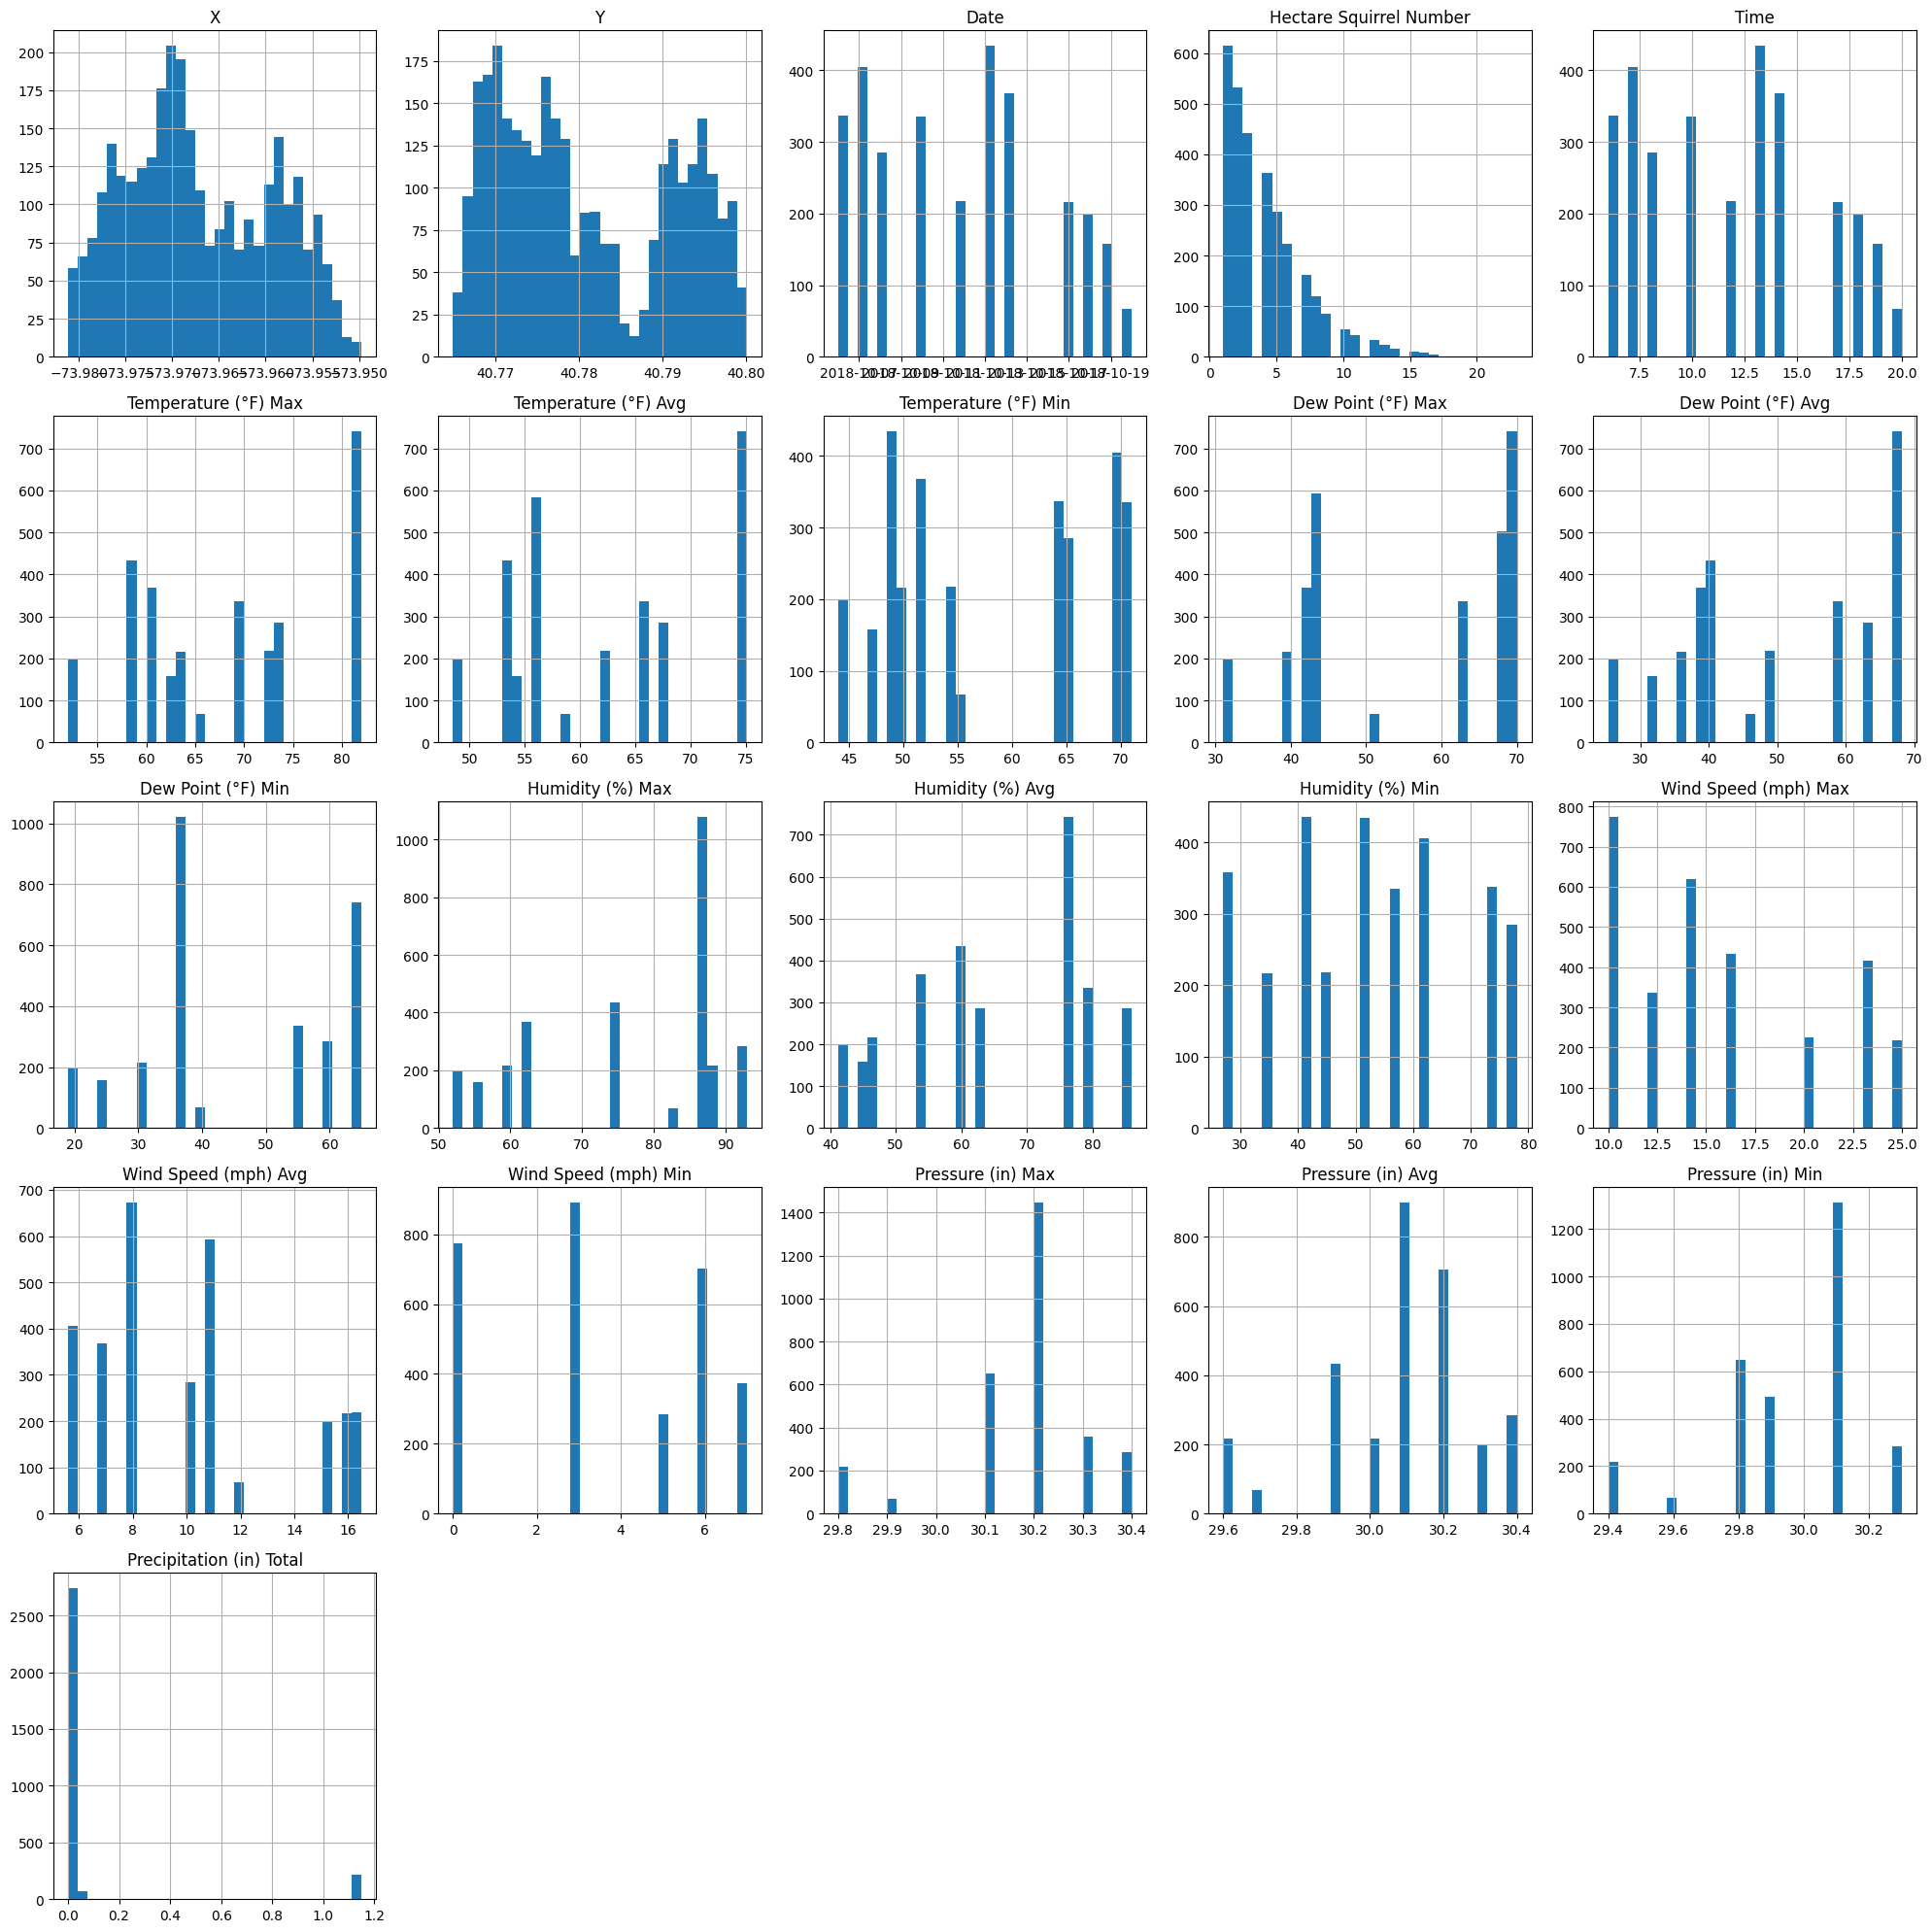

In [8]:
data.hist(figsize=(20, 20), bins=30)
plt.tight_layout()
plt.show()

In [9]:
# Extract boolean columns
boolean_columns = data.select_dtypes(include='bool').columns

# Calculate the proportion of True and False values for each boolean feature
boolean_summary = data[boolean_columns].apply(lambda x: x.value_counts(normalize=True)).T
boolean_summary.columns = ['False', 'True']

print(boolean_summary)

                  False      True
Running        0.758518  0.241482
Chasing        0.907708  0.092292
Climbing       0.782335  0.217665
Eating         0.748594  0.251406
Foraging       0.525306  0.474694
Kuks           0.966259  0.033741
Quaas          0.983460  0.016540
Moans          0.999008  0.000992
Tail flags     0.948726  0.051274
Tail twitches  0.856434  0.143566
Approaches     0.941118  0.058882
Indifferent    0.519021  0.480979
Runs from      0.775719  0.224281
Diseased       0.893483  0.106517


### Behavioral Feature Stratification Analysis

**Heavily Imbalanced Features**:
   - Features like `Kuks`, `Quaas`, `Moans`, and `Tail flags` are highly imbalanced, with few True values.
   - **Stratifying these features** may enhance model performance by ensuring adequate representation of both states, especially if these behaviors relate to sickness.

**Moderately Imbalanced Features**:
   - `Climbing`, `Eating`, `Tail twitches`, and `Runs from` show moderate imbalance. Consider stratifying these if they correlate with the target, though it's less critical than for heavily imbalanced features.

**Balanced Features**:
   - `Foraging` and `Indifferent` are well-balanced between True and False, so stratification is likely unnecessary.

**Target Label - Diseased**:
   - `Diseased` is moderately imbalanced, with True cases around 10.6%. **Stratifying this label is crucial** to maintain a balanced representation of both classes in each training split.


In [10]:
from scipy.stats import chi2_contingency

# Extract object columns
object_columns = data.select_dtypes(include='object').columns

# Function to perform chi-square test
def chi_square_test(data, object_columns, target):
    chi2_results = {}
    for col in object_columns:
        contingency_table = pd.crosstab(data[col], data[target])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        chi2_results[col] = {'chi2': chi2, 'p-value': p}
    return chi2_results

# Perform chi-square test
chi2_results = chi_square_test(data, object_columns, 'Diseased')

# Display the results
for col, result in chi2_results.items():
    print(f"Feature: {col}, Chi2: {result['chi2']}, p-value: {result['p-value']}")

Feature: Unique Squirrel ID, Chi2: 3022.9999999999995, p-value: 0.46582421236577864
Feature: Hectare, Chi2: 558.1316815698673, p-value: 4.720787340891054e-13
Feature: Shift, Chi2: 6.808624322270109e-06, p-value: 0.9979180549889929
Feature: Age, Chi2: 10.435804722551559, p-value: 0.00541868365409623
Feature: Primary Fur Color, Chi2: 1138.5172788862726, p-value: 5.944483338009056e-248
Feature: Highlight Fur Color, Chi2: 377.6592765783757, p-value: 7.961829841523003e-76
Feature: Combination of Primary and Highlight Color, Chi2: 1177.8680894100214, p-value: 3.1444250918913405e-236
Feature: Color notes, Chi2: 165.0708349926988, p-value: 0.03527359127715566
Feature: Location, Chi2: 2.728708899814244, p-value: 0.09855893167687874
Feature: Above Ground Sighter Measurement, Chi2: 32.00645671853988, p-value: 0.8120227997348299
Feature: Specific Location, Chi2: 364.7998397435897, p-value: 0.008557371025364233
Feature: Other Activities, Chi2: 327.1990784252297, p-value: 0.19360259984991715
Feature

### Chi-square Test Analysis for Feature Relevance to Target (Diseased)

This analysis assesses the association between each categorical feature and the target variable (`Diseased`) using the Chi-square test of independence. The Chi-square statistic (`chi2`) and p-value are reported for each feature, helping to identify features that may have predictive value.

#### Key Findings

1. **Significant Features (p-value < 0.05)**
   - **Hectare** (Chi2: 558.13, p-value: 4.72e-13): Indicates a strong association with `Diseased`, suggesting that squirrel density by park section could be relevant for predicting sickness.
   - **Primary Fur Color** (Chi2: 1138.52, p-value: 5.94e-248) and **Highlight Fur Color** (Chi2: 377.66, p-value: 7.96e-76): These fur color features have significant associations with the target, implying that certain fur colors may be indicators of sickness.
   - **Combination of Primary and Highlight Color** (Chi2: 1177.87, p-value: 3.14e-236): This combination is also strongly associated with `Diseased`, reinforcing the relevance of color attributes in the model.
   - **Color Notes** (Chi2: 165.07, p-value: 0.035): Although less strongly, this feature shows a significant association, indicating some potential relevance.
   - **Age** (Chi2: 10.44, p-value: 0.005): Suggests that age group may be relevant, with differences in sickness incidence between juveniles and adults.

   These features should be prioritized in the model and considered for stratification to ensure diverse representation across significant categories.

2. **Non-significant Features (p-value > 0.05)**
   - **Unique Squirrel ID** (p-value: 0.47) and **Shift (AM/PM)** (p-value: 0.99): These features show no significant association with `Diseased`, suggesting minimal predictive value.
   - **Lat/Long** (p-value: 0.49), **Location** (p-value: 0.10), and **Other Interactions** (p-value: 0.22): These features also lack statistical significance, indicating they may not contribute meaningful insights into the target label.

### Results

Based on the Chi-square test results:
   - **Include** significant features like `Hectare`, `Primary Fur Color`, `Highlight Fur Color`, and `Combination of Primary and Highlight Color`, as they show strong associations with the target and may enhance model accuracy.
   - **Exclude** non-significant features such as `Unique Squirrel ID`, `Shift`, and `Lat/Long`, as they are unlikely to impact the target variable.



In [11]:
# Function to calculate the proportion of each category in object columns
def calculate_proportions(data, object_columns):
    proportions = {}
    for col in object_columns:
        proportions[col] = data[col].value_counts(normalize=True)
    return proportions

# Calculate proportions for object columns
object_proportions = calculate_proportions(data, object_columns)

# Display the proportions
for col, prop in object_proportions.items():
    print(f"Proportions for {col}:\n{prop}\n")

# Determine if stratification is needed based on the proportions
stratify_columns = [col for col, prop in object_proportions.items() if prop.max() > 0.75]
print(f"Columns to stratify: {stratify_columns}")

Proportions for Unique Squirrel ID:
Unique Squirrel ID
7D-PM-1010-01     0.000662
40B-AM-1019-06    0.000662
37E-PM-1006-03    0.000662
4C-PM-1010-05     0.000662
1F-AM-1010-04     0.000662
                    ...   
13F-AM-1007-01    0.000331
12D-AM-1013-02    0.000331
2F-AM-1006-03     0.000331
9H-PM-1018-04     0.000331
5E-PM-1012-01     0.000331
Name: proportion, Length: 3018, dtype: float64

Proportions for Hectare:
Hectare
14D    0.010586
32E    0.009924
14E    0.009262
01B    0.008932
07H    0.008601
         ...   
11C    0.000331
23D    0.000331
26B    0.000331
24B    0.000331
30F    0.000331
Name: proportion, Length: 339, dtype: float64

Proportions for Shift:
Shift
PM    0.554416
AM    0.445584
Name: proportion, dtype: float64

Proportions for Age:
Age
Adult       0.884907
Juvenile    0.113715
?           0.001378
Name: proportion, dtype: float64

Proportions for Primary Fur Color:
Primary Fur Color
Gray        0.833221
Cinnamon    0.132075
Black       0.034704
Name: proport

### Stratification Analysis for Object Squirrel Dataset

This analysis identifies key features that may benefit from stratification to improve model performance and ensure balanced representation across groups. Stratification decisions are based on Chi-square test significance, feature distribution, and domain relevance.

#### Features Recommended for Stratification

1. **Hectare**:
   - **Reason**: Significant association with `Diseased` and noticeable imbalance in distribution across park sections. Stratifying by `Hectare` ensures diverse regional representation, capturing potential differences in disease prevalence by area.

2. **Shift (AM/PM)**:
   - **Reason**: Slight imbalance between AM and PM shifts. Although the Chi-square test did not show a strong association, time of day could impact squirrel behavior and sickness likelihood.
   - **Action**: Stratify to ensure both shifts are well-represented.

3. **Age**:
   - **Reason**: Significant association with `Diseased` and strong imbalance (mostly Adult). Age may impact disease susceptibility, so maintaining balanced age groups is important for generalization.
   - **Action**: Stratify by age to prevent bias toward adult squirrels.

4. **Primary Fur Color** and **Highlight Fur Color**:
   - **Reason**: Both fur color features have a significant association with `Diseased` and show imbalances (e.g., Gray is the predominant primary color). Fur color may be linked to disease risk.
   - **Action**: Stratify by color to ensure minority color groups are included.

5. **Combination of Primary and Highlight Color**:
   - **Reason**: Strong association with `Diseased` and varied distribution among color combinations, which may provide additional predictive power.
   - **Action**: Stratify by common combinations to enhance robustness across color patterns.

6. **Location**:
   - **Reason**: Imbalance between Ground Plane and Above Ground locations. Location could influence disease exposure or behavior.
   - **Action**: Stratify to ensure representation of both ground and above-ground sightings.

#### Features Excluded from Stratification

1. **Unique Squirrel ID** and **Lat/Long**:
   - **Reason**: No significant association with `Diseased` and primarily act as identifiers. These features do not contribute predictive value.
   - **Action**: Exclude from stratification.

2. **Specific Location**, **Other Activities**, **Other Interactions**, and **Color Notes**:
   - **Reason**: Limited association with `Diseased` and highly detailed categories, which may not meaningfully impact the target variable.
   - **Action**: Exclude from stratification unless further analysis suggests they are essential.

### Summary
The following features are recommended for stratification to enhance model performance and generalization: `Hectare`, `Shift`, `Age`, `Primary Fur Color`, `Highlight Fur Color`, `Combination of Primary and Highlight Color`, and `Location`. This approach ensures balanced representation across significant groups, supporting more accurate predictions of squirrel disease likelihood.


In [12]:
#show all columns
pd.set_option('display.max_columns', None)

data

X          Y Unique Squirrel ID Hectare Shift       Date  \
0    -73.956134  40.794082     37F-PM-1014-03     37F    PM 2018-10-14   
1    -73.968857  40.783783     21B-AM-1019-04     21B    AM 2018-10-19   
2    -73.974281  40.775534     11B-PM-1014-08     11B    PM 2018-10-14   
3    -73.959641  40.790313     32E-PM-1017-14     32E    PM 2018-10-17   
4    -73.970268  40.776213     13E-AM-1017-05     13E    AM 2018-10-17   
...         ...        ...                ...     ...   ...        ...   
3018 -73.963943  40.790868     30B-AM-1007-04     30B    AM 2018-10-07   
3019 -73.970402  40.782560     19A-PM-1013-05     19A    PM 2018-10-13   
3020 -73.966587  40.783678     22D-PM-1012-07     22D    PM 2018-10-12   
3021 -73.963994  40.789915     29B-PM-1010-02     29B    PM 2018-10-10   
3022 -73.975479  40.769640      5E-PM-1012-01     05E    PM 2018-10-12   

      Hectare Squirrel Number    Age Primary Fur Color  \
0                           3    NaN               NaN   
1                           4    NaN               NaN   
2                           8    NaN              Gray   
3                          14  Adult              Gray   
4                           5  Adult              Gray   
...                       ...    ...               ...   
3018                        4  Adult              Gray   
3019                        5  Adult              Gray   
3020                        7  Adult              Gray   
3021                        2    NaN              Gray   
3022                        1  Adult          Cinnamon   

         Highlight Fur Color Combination of Primary and Highlight Color  \
0                        NaN                                          +   
1                        NaN                                          +   
2                        NaN                                      Gray+   
3                        NaN                                      Gray+   
4                   Cinnamon                              Gray+Cinnamon   
...                      ...                                        ...   
3018                     NaN                                      Gray+   
3019                   White                                 Gray+White   
3020  Black, Cinnamon, White                Gray+Black, Cinnamon, White   
3021         Cinnamon, White                       Gray+Cinnamon, White   
3022             Gray, White                       Cinnamon+Gray, White   

                                            Color notes      Location  \
0                                                   NaN           NaN   
1                                                   NaN           NaN   
2                                                   NaN  Above Ground   
3     Nothing selected as Primary. Gray selected as ...           NaN   
4                                                   NaN  Above Ground   
...                                                 ...           ...   
3018                                                NaN  Ground Plane   
3019                                                NaN  Ground Plane   
3020                                                NaN  Ground Plane   
3021                                                NaN  Ground Plane   
3022                                                NaN  Ground Plane   

     Above Ground Sighter Measurement Specific Location  Running  Chasing  \
0                                 NaN               NaN    False    False   
1                                 NaN               NaN    False    False   
2                                  10               NaN    False     True   
3                                 NaN               NaN    False    False   
4                                 NaN     on tree stump    False    False   
...                               ...               ...      ...      ...   
3018                            FALSE               NaN    False    False   
3019                            FA

In [13]:
#train test split 
from sklearn.model_selection import train_test_split

X = data.drop('Diseased', axis=1)
y = data['Diseased']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Didnt stratify moan because so little data it was impossible to stratify.

# Data Visualization

In [14]:
# create train set which has target and other columns
train = X_train.copy()
train['Diseased'] = y_train

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Hectare Squirrel Number'}>,
        <Axes: title={'center': 'Time'}>],
       [<Axes: title={'center': 'Temperature (°F) Max'}>,
        <Axes: title={'center': 'Temperature (°F) Avg'}>,
        <Axes: title={'center': 'Temperature (°F) Min'}>,
        <Axes: title={'center': 'Dew Point (°F) Max'}>,
        <Axes: title={'center': 'Dew Point (°F) Avg'}>],
       [<Axes: title={'center': 'Dew Point (°F) Min'}>,
        <Axes: title={'center': 'Humidity (%) Max'}>,
        <Axes: title={'center': 'Humidity (%) Avg'}>,
        <Axes: title={'center': 'Humidity (%) Min'}>,
        <Axes: title={'center': 'Wind Speed (mph) Max'}>],
       [<Axes: title={'center': 'Wind Speed (mph) Avg'}>,
        <Axes: title={'center': 'Wind Speed (mph) Min'}>,
        <Axes: title={'center': 'Pressure (in) Max'}>,
        <Axes: title={'center': 'Pressure (in) Av

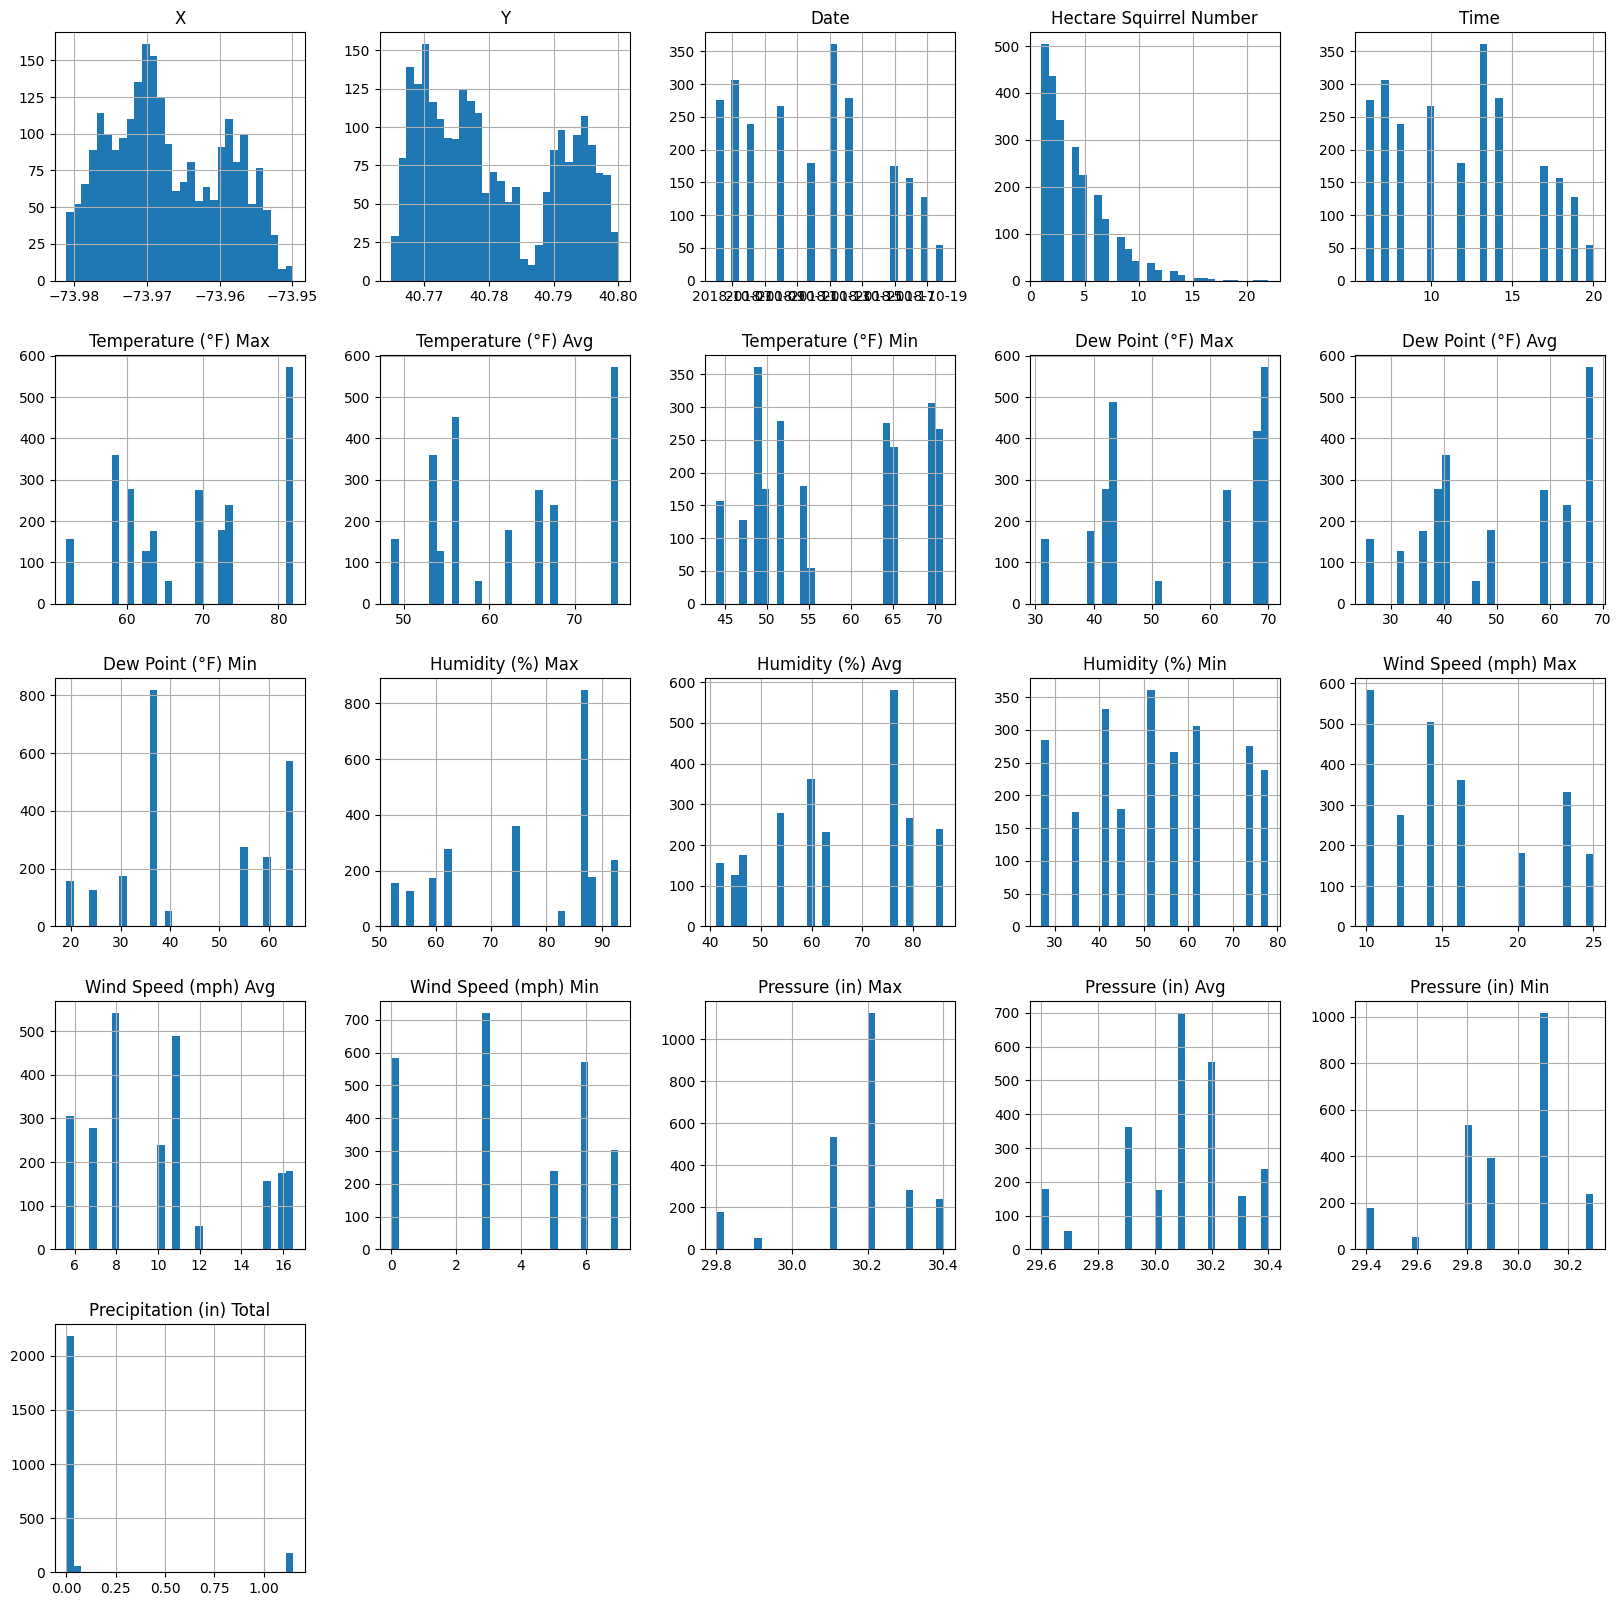

In [15]:
#histrogram of train set for numerical columns
train.hist(figsize=(20, 20), bins=30)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2418 entries, 1403 to 1006
Data columns (total 48 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           2418 non-null   float64       
 1   Y                                           2418 non-null   float64       
 2   Unique Squirrel ID                          2418 non-null   object        
 3   Hectare                                     2418 non-null   object        
 4   Shift                                       2418 non-null   object        
 5   Date                                        2418 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     2418 non-null   int64         
 7   Age                                         2330 non-null   object        
 8   Primary Fur Color                           2378 non-null   object        
 9   Highlight 

<Axes: xlabel='Unique Squirrel ID', ylabel='count'>

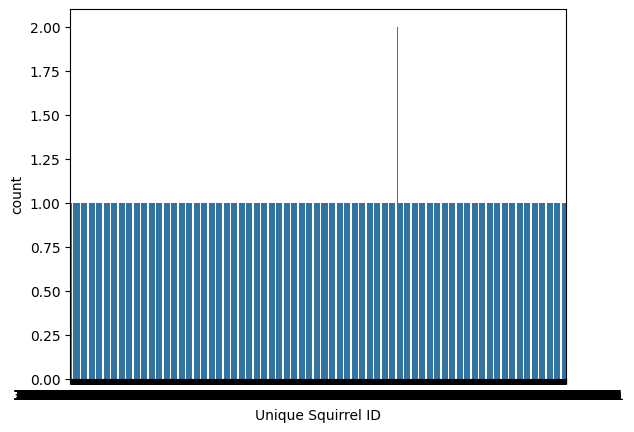

In [17]:
# plot Unique Squirrel ID

sns.countplot(data=train, x='Unique Squirrel ID')


<Axes: xlabel='Hectare', ylabel='count'>

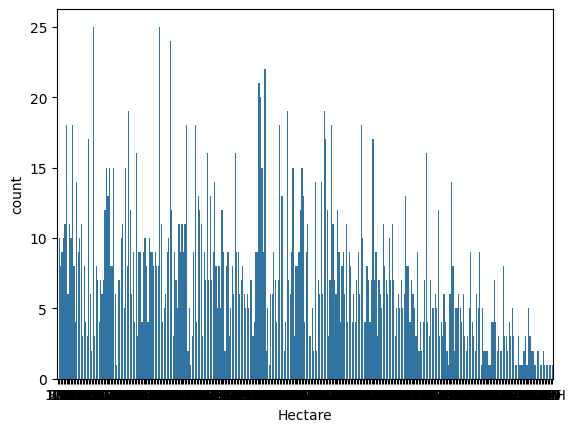

In [18]:
# plot Hectare

sns.countplot(data=train, x='Hectare')

<Axes: xlabel='Shift', ylabel='count'>

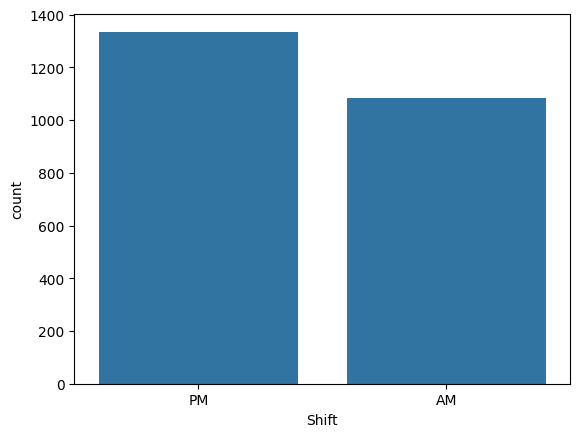

In [19]:
# plot Shift

sns.countplot(data=train, x='Shift')

<Axes: xlabel='Age', ylabel='count'>

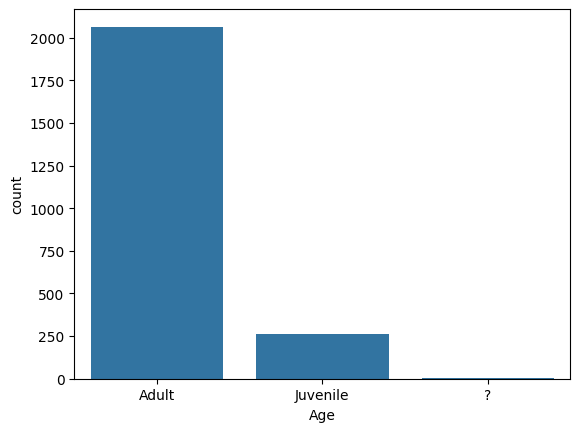

In [20]:
# plot Age

sns.countplot(data=train, x='Age')

<Axes: xlabel='Primary Fur Color', ylabel='count'>

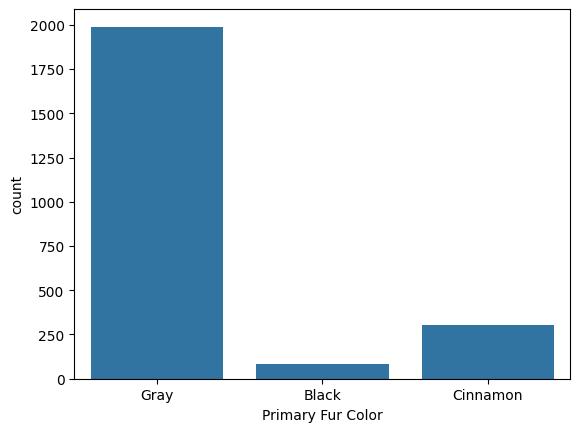

In [21]:
# plot Primary Fur Color

sns.countplot(data=train, x='Primary Fur Color')

<Axes: xlabel='Highlight Fur Color', ylabel='count'>

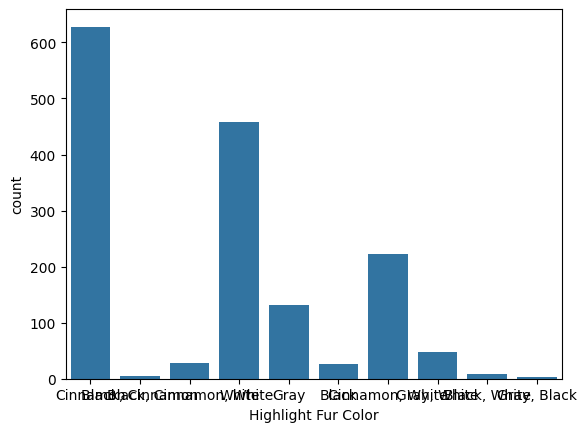

In [22]:
# plot Highlight Fur Color

sns.countplot(data=train, x='Highlight Fur Color')

<Axes: xlabel='Combination of Primary and Highlight Color', ylabel='count'>

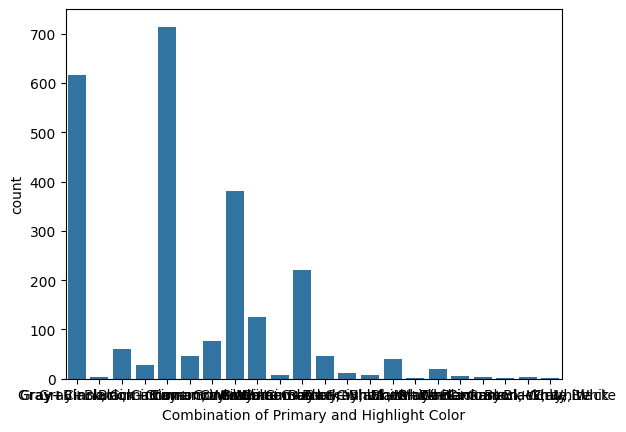

In [23]:
# plot Combination of Primary and Highlight Color

sns.countplot(data=train, x='Combination of Primary and Highlight Color')

<Axes: xlabel='Color notes', ylabel='count'>

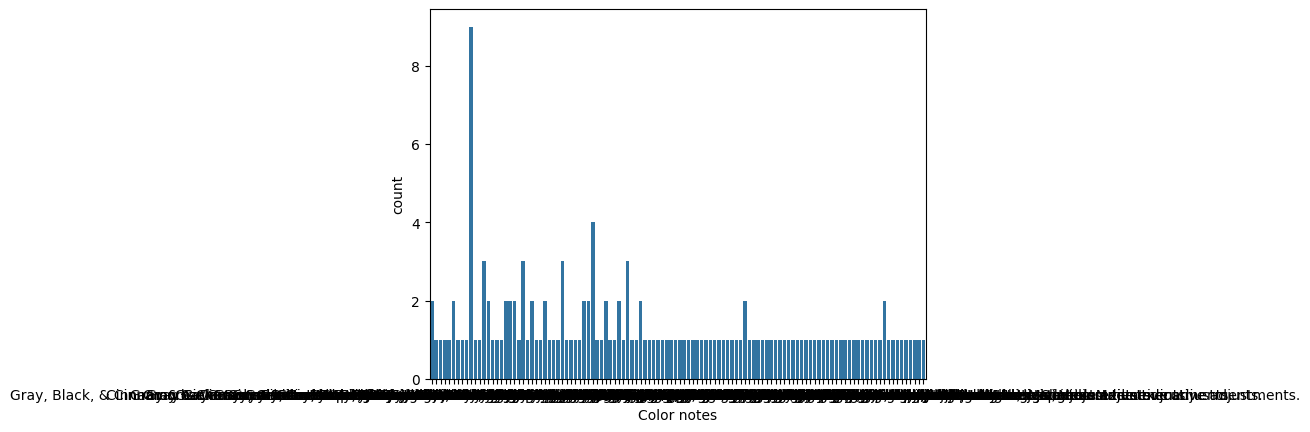

In [24]:
# plot Color notes

sns.countplot(data=train, x='Color notes')

<Axes: xlabel='Location', ylabel='count'>

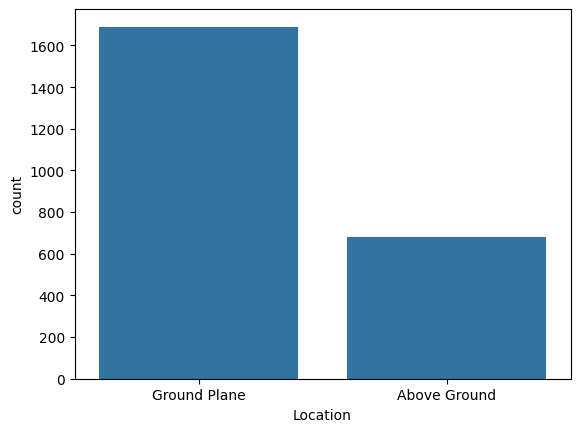

In [25]:
# plot Location

sns.countplot(data=train, x='Location')

<Axes: xlabel='Above Ground Sighter Measurement', ylabel='count'>

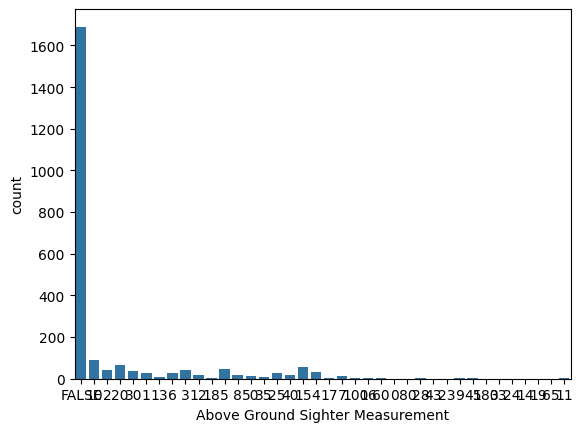

In [26]:
# plot Above Ground Sighter Measurement

sns.countplot(data=train, x='Above Ground Sighter Measurement')

<Axes: xlabel='Specific Location', ylabel='count'>

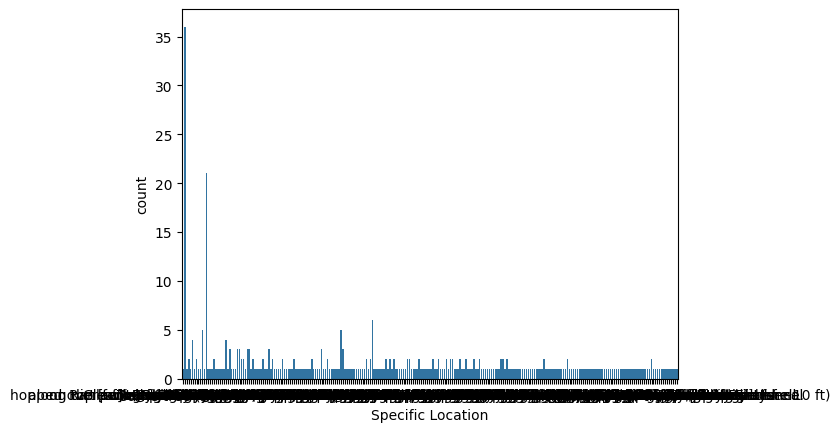

In [27]:
# plot Specific Location

sns.countplot(data=train, x='Specific Location')

In [ ]:
train['Specific Location'].value_counts()

Specific Location
tree          36
in tree       21
Tree           6
on fence       5
treed area     5
              ..
on hill        1
A rock         1
rocks          1
On a rock      1
up tree        1
Name: count, Length: 254, dtype: int64

<Axes: xlabel='Running', ylabel='count'>

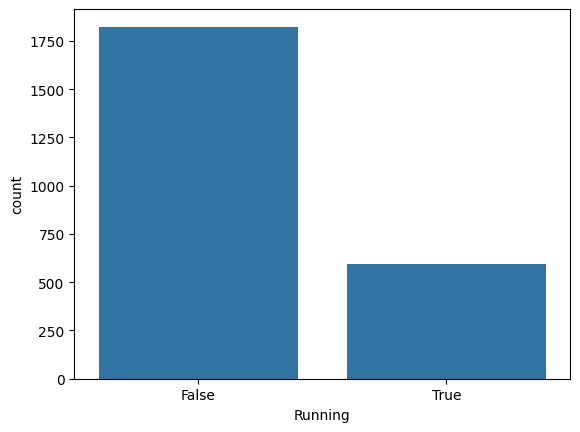

In [29]:
# plot Running

sns.countplot(data=train, x='Running')

<Axes: xlabel='Chasing', ylabel='count'>

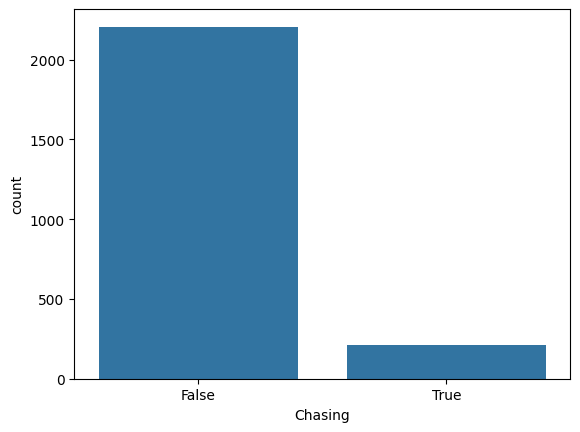

In [30]:
# plot Chasing

sns.countplot(data=train, x='Chasing')

<Axes: xlabel='Climbing', ylabel='count'>

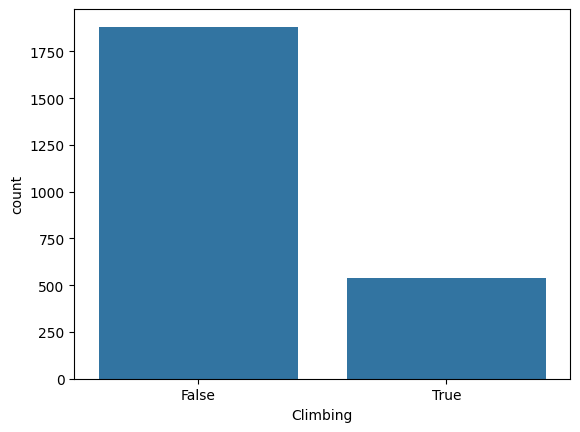

In [31]:
# plot Climbing

sns.countplot(data=train, x='Climbing')

<Axes: xlabel='Eating', ylabel='count'>

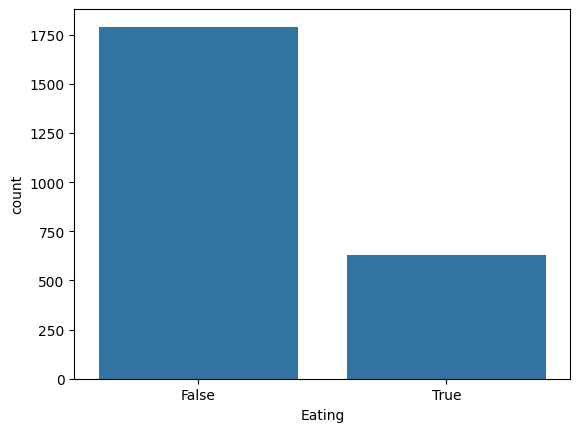

In [32]:
# plot Eating

sns.countplot(data=train, x='Eating')

<Axes: xlabel='Foraging', ylabel='count'>

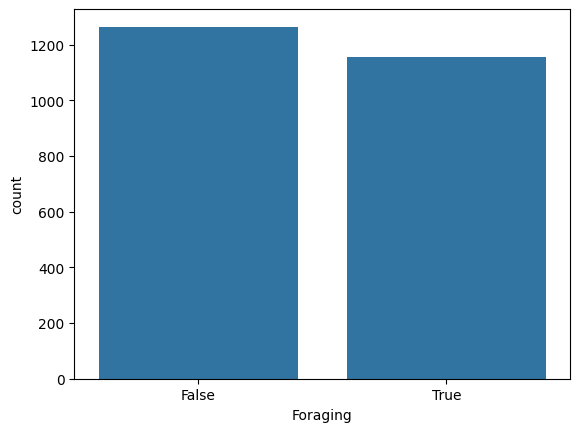

In [33]:
# plot Foraging

sns.countplot(data=train, x='Foraging')

<Axes: xlabel='Other Activities', ylabel='count'>

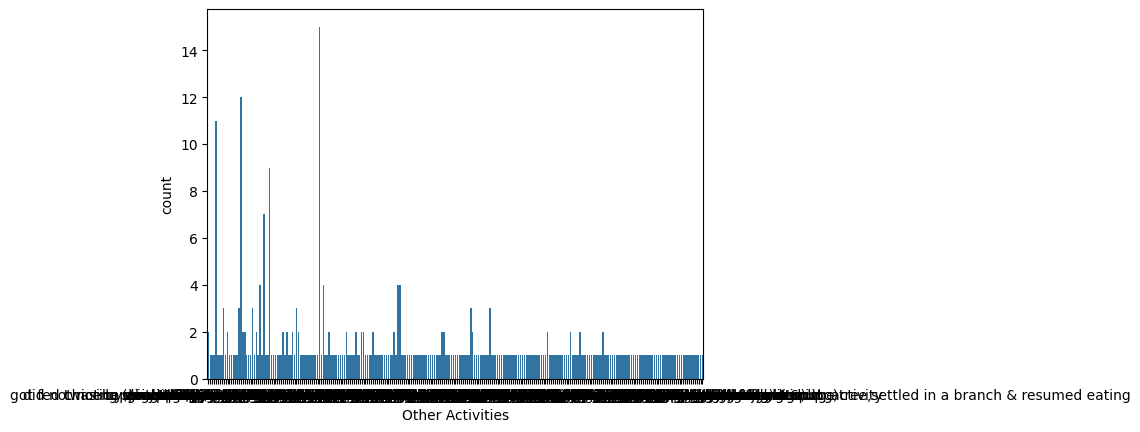

In [34]:
# plot Other Activities

sns.countplot(data=train, x='Other Activities')

<Axes: xlabel='Kuks', ylabel='count'>

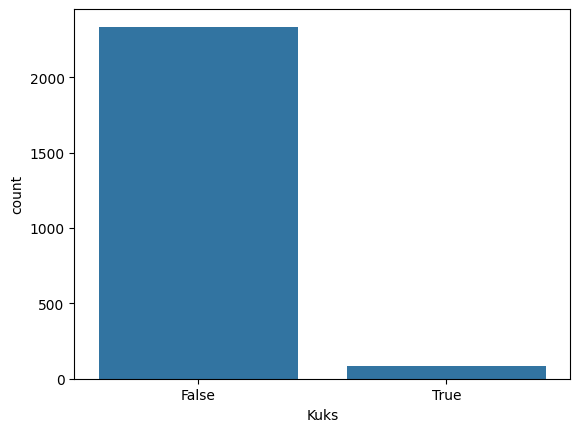

In [35]:
# plot Kuks

sns.countplot(data=train, x='Kuks')

<Axes: xlabel='Quaas', ylabel='count'>

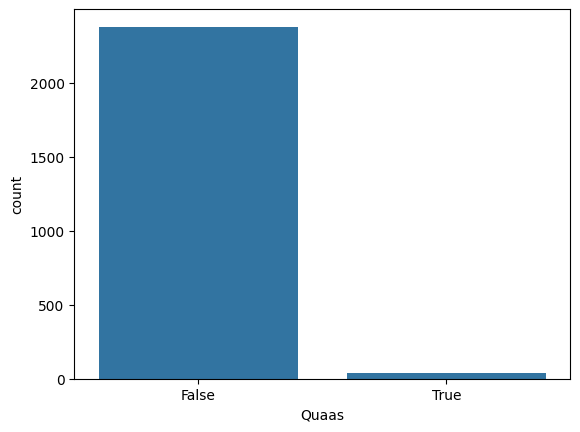

In [36]:
# plot Quaas

sns.countplot(data=train, x='Quaas')

<Axes: xlabel='Moans', ylabel='count'>

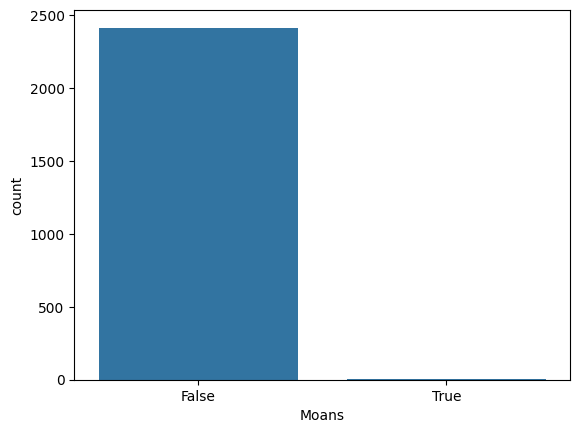

In [37]:
# plot Moans

sns.countplot(data=train, x='Moans')

<Axes: xlabel='Tail flags', ylabel='count'>

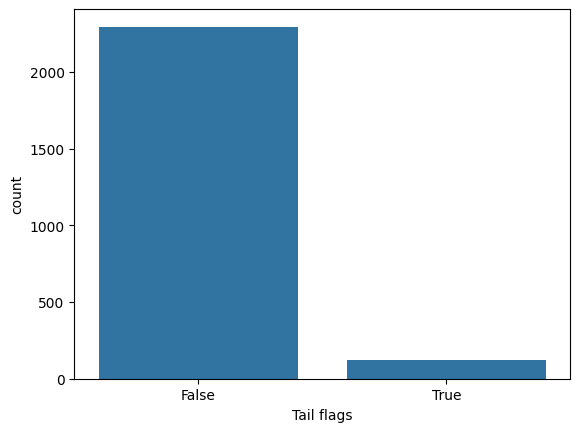

In [38]:
# plot Tail flags

sns.countplot(data=train, x='Tail flags')

<Axes: xlabel='Tail twitches', ylabel='count'>

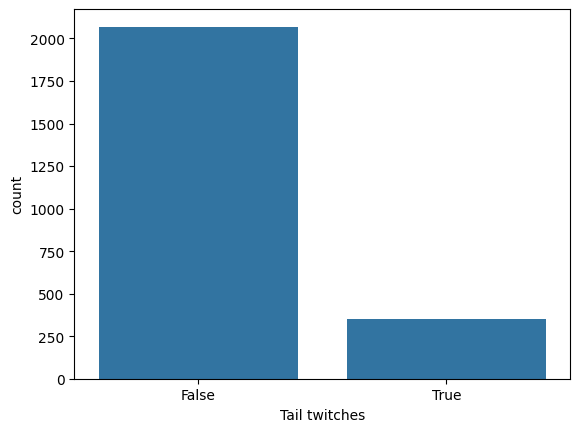

In [39]:
# plot Tail twitches

sns.countplot(data=train, x='Tail twitches')

<Axes: xlabel='Approaches', ylabel='count'>

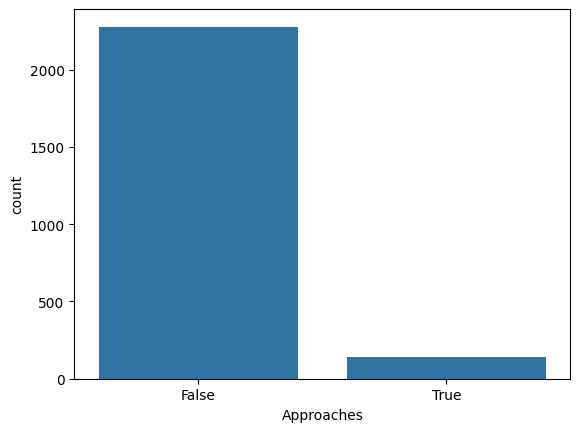

In [40]:
# plot Approaches

sns.countplot(data=train, x='Approaches')

<Axes: xlabel='Indifferent', ylabel='count'>

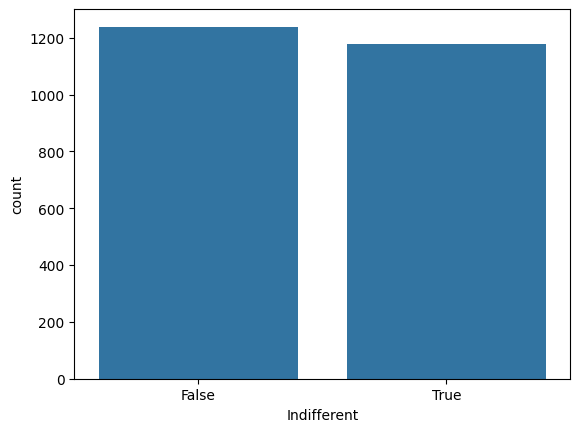

In [41]:
# plot Indifferent

sns.countplot(data=train, x='Indifferent')

<Axes: xlabel='Runs from', ylabel='count'>

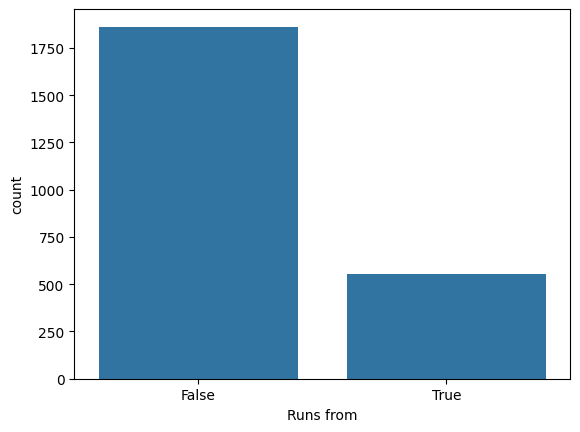

In [42]:
# plot Runs from 

sns.countplot(data=train, x='Runs from')

<Axes: xlabel='Other Interactions', ylabel='count'>

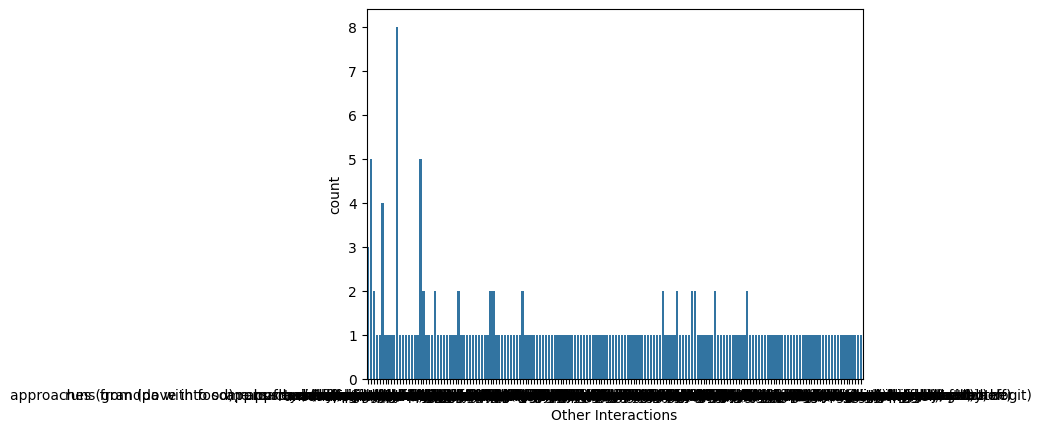

In [43]:
# plot Other Interactions

sns.countplot(data=train, x='Other Interactions')

<Axes: xlabel='Lat/Long', ylabel='count'>

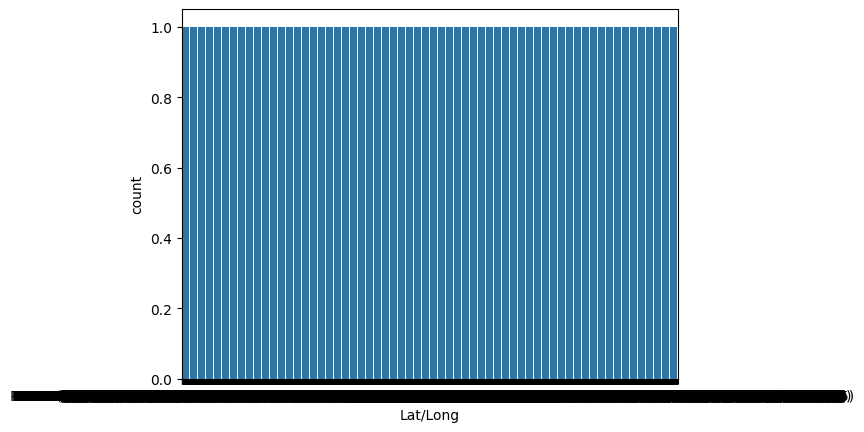

In [44]:
# plot Lat/Long

sns.countplot(data=train, x='Lat/Long')

<Axes: xlabel='Diseased', ylabel='count'>

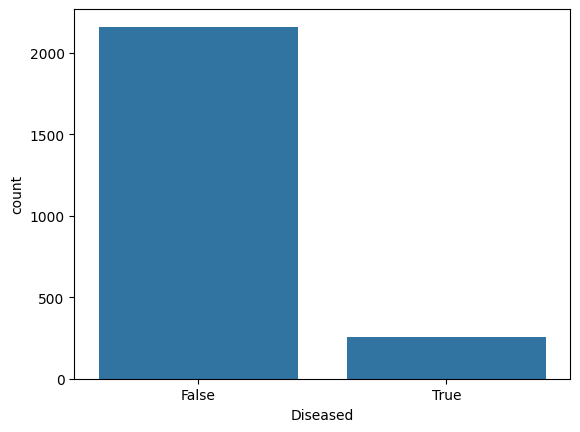

In [45]:
# plot Diseased

sns.countplot(data=train, x='Diseased')

In [46]:
# Convert all boolean columns to integers (0 and 1) for correlation checking
train = train.astype({col: 'int' for col in train.select_dtypes(include='bool').columns})

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2418 entries, 1403 to 1006
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           2418 non-null   float64       
 1   Y                                           2418 non-null   float64       
 2   Unique Squirrel ID                          2418 non-null   object        
 3   Hectare                                     2418 non-null   object        
 4   Shift                                       2418 non-null   object        
 5   Date                                        2418 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     2418 non-null   int64         
 7   Age                                         2330 non-null   object        
 8   Primary Fur Color                           2378 non-null   object        
 9   Highlight 

In [48]:
train['Age'].value_counts()

Age
Adult       2064
Juvenile     264
?              2
Name: count, dtype: int64

In [49]:
# make new Column for Age called Age_Adult and make it 1 for being Adult and 0 for not being adult

train['Age_Adult'] = train['Age'].apply(lambda x: 1 if x == 'Adult' else 0)

train['Age_Adult'].value_counts()

Age_Adult
1    2064
0     354
Name: count, dtype: int64

In [50]:
# make new Column for Age called Age_Juvenile and make it 1 for being Juvenile and 0 for not being Juvenile

train['Age_Juvenile'] = train['Age'].apply(lambda x: 1 if x == 'Juvenile' else 0)

train['Age_Juvenile'].value_counts()

Age_Juvenile
0    2154
1     264
Name: count, dtype: int64

In [51]:
# make new Column for Age called Age_Unknown and make it 1 for being Unknown and 0 for not being Unknown

train['Age_Unknown'] = train['Age'].apply(lambda x: 1 if x == '?' else 0)

train['Age_Unknown'].value_counts()

Age_Unknown
0    2416
1       2
Name: count, dtype: int64

In [52]:
train['Shift'].value_counts()

Shift
PM    1335
AM    1083
Name: count, dtype: int64

In [53]:
# create new shift column Shift_Binary and make it 1 for being PM and 0 for being AM

train['Shift_Binary'] = train['Shift'].apply(lambda x: 1 if x == 'PM' else 0)

train['Shift_Binary'].value_counts()


Shift_Binary
1    1335
0    1083
Name: count, dtype: int64

In [54]:
train['Primary Fur Color'].value_counts()

Primary Fur Color
Gray        1989
Cinnamon     306
Black         83
Name: count, dtype: int64

In [55]:
# create new column for Primary Fur Color Gray

train['Primary Fur Color_Gray'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Gray' else 0)

Gray= train['Primary Fur Color_Gray'].value_counts()

# create new column for Primary Fur Color Cinnamon

train['Primary Fur Color_Cinnamon'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Cinnamon' else 0)

Cinnamon = train['Primary Fur Color_Cinnamon'].value_counts()

# create new column for Primary Fur Color Black

train['Primary Fur Color_Black'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Black' else 0)

Black = train['Primary Fur Color_Black'].value_counts()

Gray, Cinnamon, Black

(Primary Fur Color_Gray
 1    1989
 0     429
 Name: count, dtype: int64,
 Primary Fur Color_Cinnamon
 0    2112
 1     306
 Name: count, dtype: int64,
 Primary Fur Color_Black
 0    2335
 1      83
 Name: count, dtype: int64)

In [56]:
train['Highlight Fur Color'].value_counts()

Highlight Fur Color
Cinnamon                  628
White                     458
Cinnamon, White           223
Gray                      131
Gray, White                47
Black, Cinnamon, White     28
Black                      26
Black, White                8
Black, Cinnamon             4
Gray, Black                 3
Name: count, dtype: int64

In [57]:
# break up highlight fur color into new columns Black, White, Gray, Cinnamon. If the color is present, the value is 1

#in case there is NA values, fill them with empty string for separation
train['Highlight Fur Color'] = train['Highlight Fur Color'].fillna('').astype(str)

train['Highlight Fur Color_Black'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Black' in x else 0)

train['Highlight Fur Color_White'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'White' in x else 0)

train['Highlight Fur Color_Gray'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Gray' in x else 0)

train['Highlight Fur Color_Cinnamon'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Cinnamon' in x else 0)

train['Highlight Fur Color_Black'].value_counts(), train['Highlight Fur Color_White'].value_counts(), train['Highlight Fur Color_Gray'].value_counts(), train['Highlight Fur Color_Cinnamon'].value_counts()

(Highlight Fur Color_Black
 0    2349
 1      69
 Name: count, dtype: int64,
 Highlight Fur Color_White
 0    1654
 1     764
 Name: count, dtype: int64,
 Highlight Fur Color_Gray
 0    2237
 1     181
 Name: count, dtype: int64,
 Highlight Fur Color_Cinnamon
 0    1535
 1     883
 Name: count, dtype: int64)

In [58]:
train['Color notes'].value_counts()

Color notes
Gray & Cinnamon selected as Primary. White selected as Highlights. Made executive adjustments.                     9
white belly                                                                                                        4
white back legs                                                                                                    3
Listed as primary white with cinnamon highlights, I changed to Gray/cinnamon - JO                                  3
White tail                                                                                                         3
                                                                                                                  ..
Can't tell :(                                                                                                      1
Gray & Cinnamon selected as Primary: "much browner, like 1/2 & 1/2".                                               1
Gray & Cinnamon selected as Primary. Gray, Cinnamon 

In [59]:
train['Combination of Primary and Highlight Color'].value_counts()

Combination of Primary and Highlight Color
Gray+                          714
Gray+Cinnamon                  617
Gray+White                     380
Gray+Cinnamon, White           220
Cinnamon+Gray                  126
Cinnamon+White                  76
Black+                          61
Cinnamon+                       47
Cinnamon+Gray, White            46
+                               40
Gray+Black, Cinnamon, White     28
Gray+Black                      19
Black+Cinnamon                  11
Cinnamon+Black                   7
Gray+Black, White                7
Black+Gray                       5
Gray+Black, Cinnamon             4
Black+Cinnamon, White            3
Cinnamon+Gray, Black             3
Black+White                      2
Cinnamon+Black, White            1
Black+Gray, White                1
Name: count, dtype: int64

In [60]:
train['Location'].value_counts()

# create new column for Location Ground Plane and Above Ground. 1 is for being Above Ground and 0 for being Ground Plane

train['Location_Binary'] = train['Location'].apply(lambda x: 1 if x == 'Ground Plane' else 0)

train['Location_Binary'].value_counts()

Location_Binary
1    1690
0     728
Name: count, dtype: int64

In [61]:
train['Above Ground Sighter Measurement'].value_counts()

Above Ground Sighter Measurement
FALSE    1690
10         88
20         67
15         58
5          48
2          42
3          42
30         36
4          33
6          28
25         26
1          26
40         20
8          19
12         16
7          15
50         14
35          9
13          9
28          5
18          5
100         4
45          4
9           4
17          3
60          2
16          2
11          2
80          1
0           1
43          1
23          1
180         1
33          1
24          1
14          1
19          1
65          1
Name: count, dtype: int64

In [62]:
train['Specific Location'].value_counts()

Specific Location
tree          36
in tree       21
Tree           6
on fence       5
treed area     5
              ..
on hill        1
A rock         1
rocks          1
On a rock      1
up tree        1
Name: count, Length: 254, dtype: int64

In [63]:
train['Hectare'].value_counts()

Hectare
14E    25
14D    25
32E    24
01B    22
13D    21
       ..
24B     1
41G     1
18E     1
23D     1
40H     1
Name: count, Length: 335, dtype: int64

In [64]:
train

X          Y Unique Squirrel ID Hectare Shift       Date  \
1403 -73.970067  40.774286     12F-PM-1007-08     12F    PM 2018-10-07   
2648 -73.970643  40.776293     13E-AM-1017-07     13E    AM 2018-10-17   
1374 -73.956474  40.793885     36F-AM-1017-03     36F    AM 2018-10-17   
548  -73.964383  40.781545     21F-PM-1018-03     21F    PM 2018-10-18   
1897 -73.971074  40.772327     10F-PM-1019-07     10F    PM 2018-10-19   
...         ...        ...                ...     ...   ...        ...   
1978 -73.968664  40.784318     22B-PM-1014-01     22B    PM 2018-10-14   
493  -73.954843  40.798207     41E-AM-1007-06     41E    AM 2018-10-07   
132  -73.952868  40.792581     36I-PM-1007-13     36I    PM 2018-10-07   
1556 -73.974624  40.767149      3F-AM-1006-06     03F    AM 2018-10-06   
1006 -73.963532  40.782135     22G-AM-1018-01     22G    AM 2018-10-18   

      Hectare Squirrel Number       Age Primary Fur Color Highlight Fur Color  \
1403                        8     Adult              Gray            Cinnamon   
2648                        7     Adult              Gray            Cinnamon   
1374                        3     Adult              Gray            Cinnamon   
548                         3     Adult              Gray            Cinnamon   
1897                        7     Adult              Gray            Cinnamon   
...                       ...       ...               ...                 ...   
1978                        1  Juvenile              Gray            Cinnamon   
493                         6     Adult              Gray                       
132                        13     Adult              Gray            Cinnamon   
1556                        6     Adult              Gray            Cinnamon   
1006                        1     Adult              Gray            Cinnamon   

     Combination of Primary and Highlight Color  \
1403                              Gray+Cinnamon   
2648                              Gray+Cinnamon   
1374                              Gray+Cinnamon   
548                               Gray+Cinnamon   
1897                              Gray+Cinnamon   
...                                         ...   
1978                              Gray+Cinnamon   
493                                       Gray+   
132                               Gray+Cinnamon   
1556                              Gray+Cinnamon   
1006                              Gray+Cinnamon   

                                            Color notes      Location  \
1403                                                NaN  Ground Plane   
2648                                                NaN  Ground Plane   
1374                              Cinnamon on shoulders  Ground Plane   
548                                                 NaN  Ground Plane   
1897                                                NaN  Above Ground   
...                                                 ...           ...   
1978                                                NaN  Ground Plane   
493                                                 NaN  Above Ground   
132                                                 NaN  Ground Plane   
1556  Gray & Cinnamon selected as Primary. Nothing s...  Ground Plane   
1006                                                NaN  Ground Plane   

     Above Ground Sighter Measurement  Specific Location  Running  Chasing  \
1403                            FALSE                NaN        0        0   
2648                            FALSE                NaN        0        0   
1374                            FALSE                NaN        0        0   
548                             FALSE                NaN        0        0   
1897                               10  Same tree (as #6)        0        0   
...                               ...                ...      ...      ...   
1978                            FALSE                NaN        0        0   
493                                30 

In [65]:
#drop Unique Squirell ID

train = train.drop('Unique Squirrel ID', axis=1)

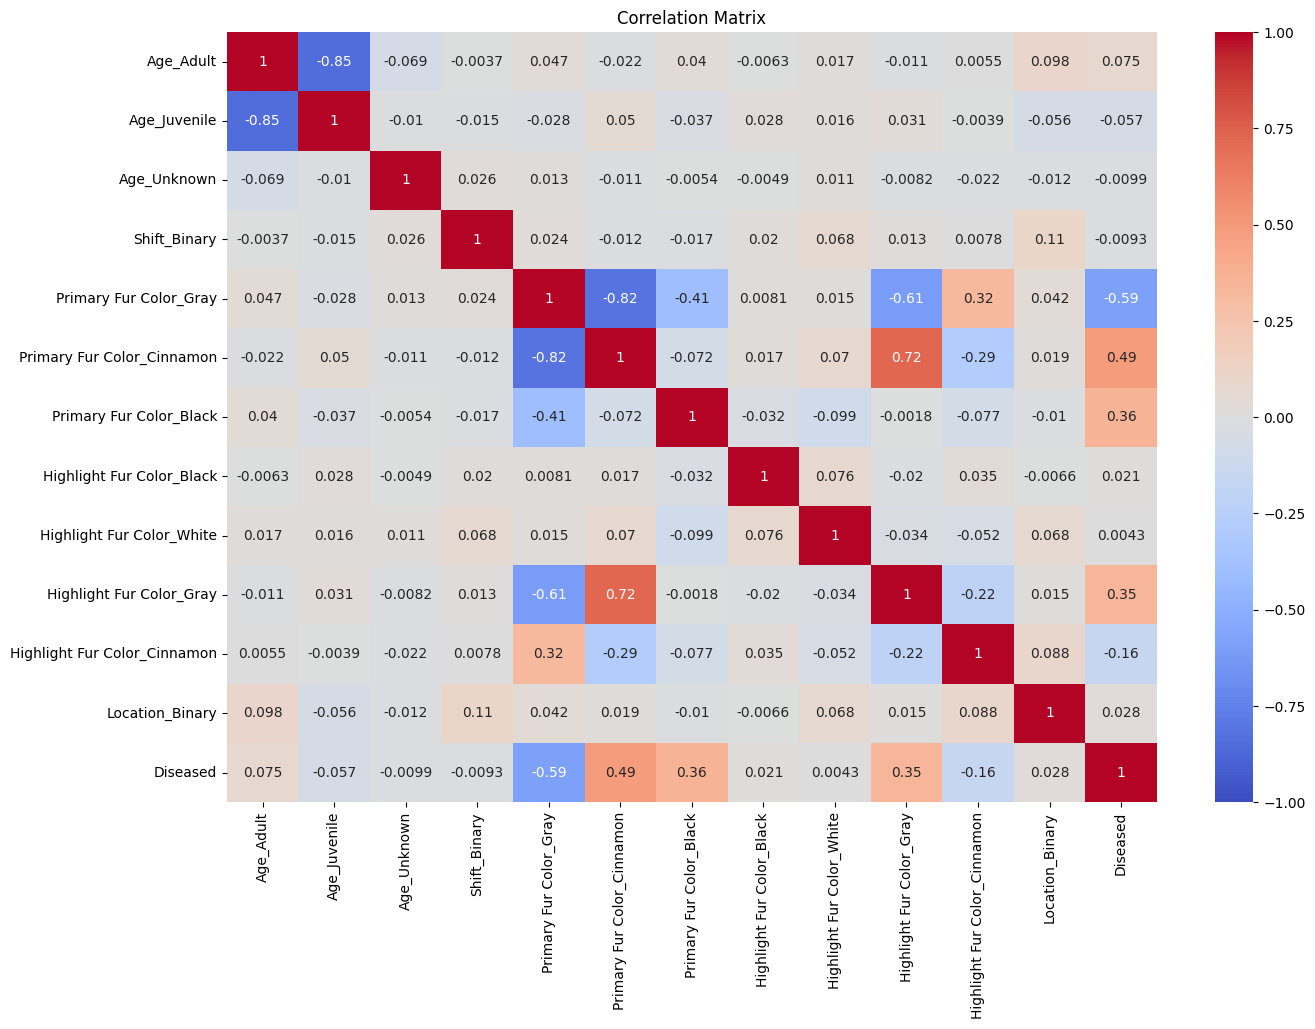

In [66]:
# heatmap of correlation matrix for Age_Adult	Age_Juvenile	Age_Unknown	Shift_Binary	Primary Fur Color_Gray	Primary Fur Color_Cinnamon	Primary Fur Color_Black	Highlight Fur Color_Black	Highlight Fur Color_White	Highlight Fur Color_Gray	Highlight Fur Color_Cinnamon	Location_Binary, Diseased

plt.figure(figsize=(15, 10))

sns.heatmap(train[['Age_Adult', 'Age_Juvenile', 'Age_Unknown', 'Shift_Binary', 'Primary Fur Color_Gray', 'Primary Fur Color_Cinnamon', 'Primary Fur Color_Black', 'Highlight Fur Color_Black', 'Highlight Fur Color_White', 'Highlight Fur Color_Gray', 'Highlight Fur Color_Cinnamon', 'Location_Binary', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()


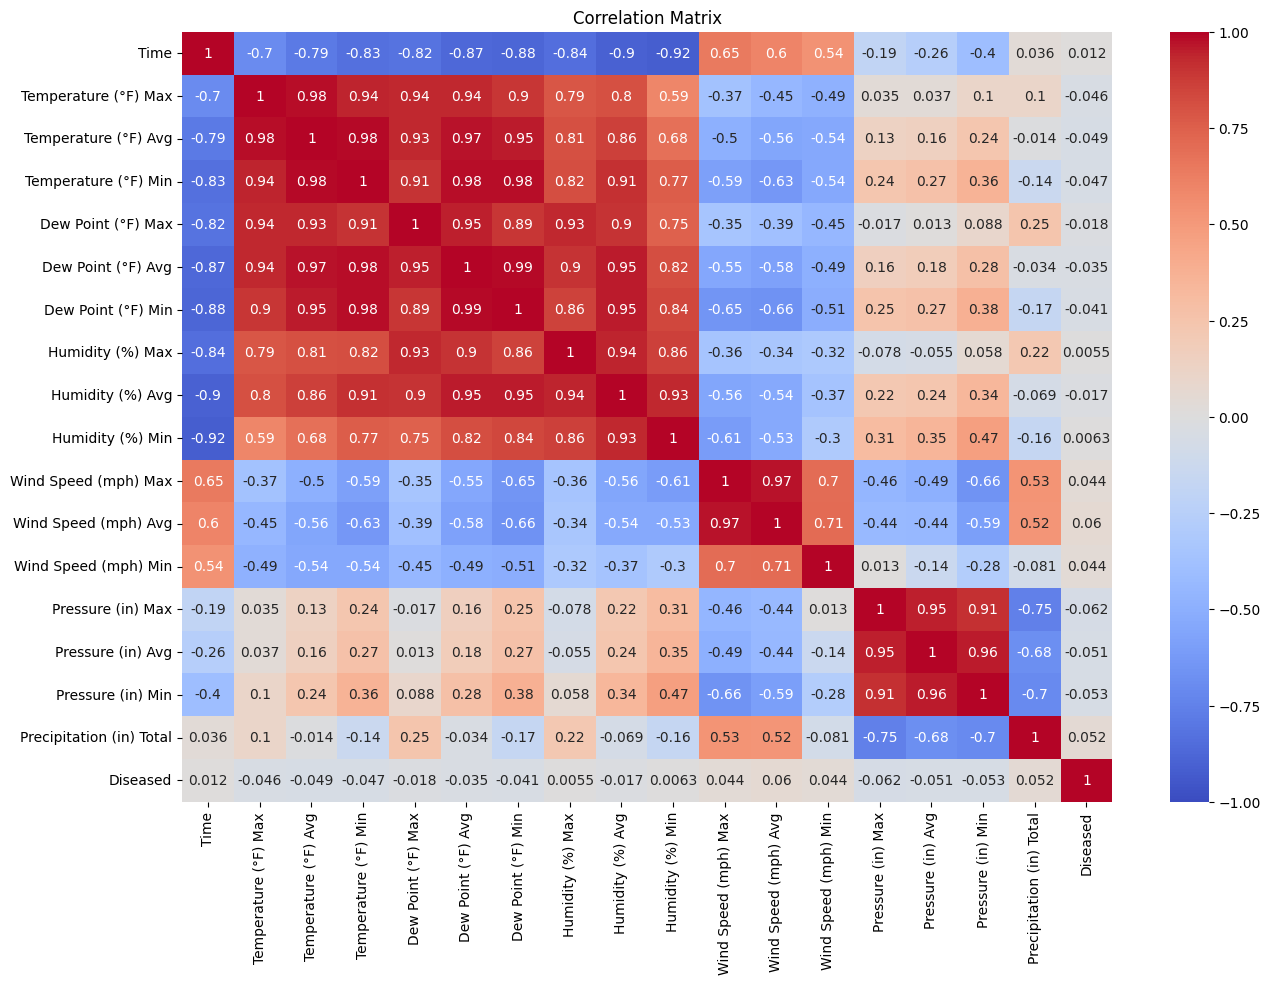

In [67]:
# heatmap of Time	Temperature (°F) Max	Temperature (°F) Avg	Temperature (°F) Min	Dew Point (°F) Max	Dew Point (°F) Avg	Dew Point (°F) Min	Humidity (%) Max	Humidity (%) Avg	Humidity (%) Min	Wind Speed (mph) Max	Wind Speed (mph) Avg	Wind Speed (mph) Min	Pressure (in) Max	Pressure (in) Avg	Pressure (in) Min	Precipitation (in) Total

plt.figure(figsize=(15, 10))

sns.heatmap(train[['Time', 'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min', 'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 'Precipitation (in) Total', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()


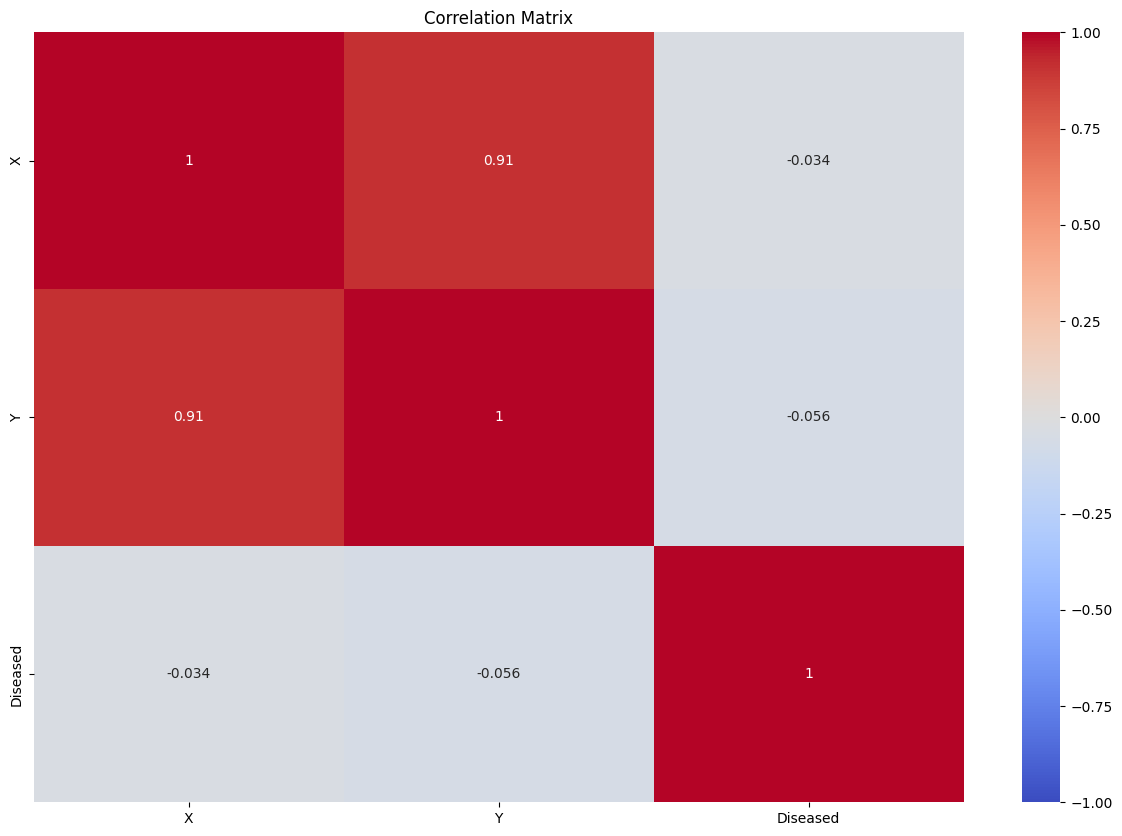

In [68]:
# heatmap of X	Y

plt.figure(figsize=(15, 10))

sns.heatmap(train[['X', 'Y', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

In [69]:
# get the day from the date

train['Day'] = train['Date'].dt.day


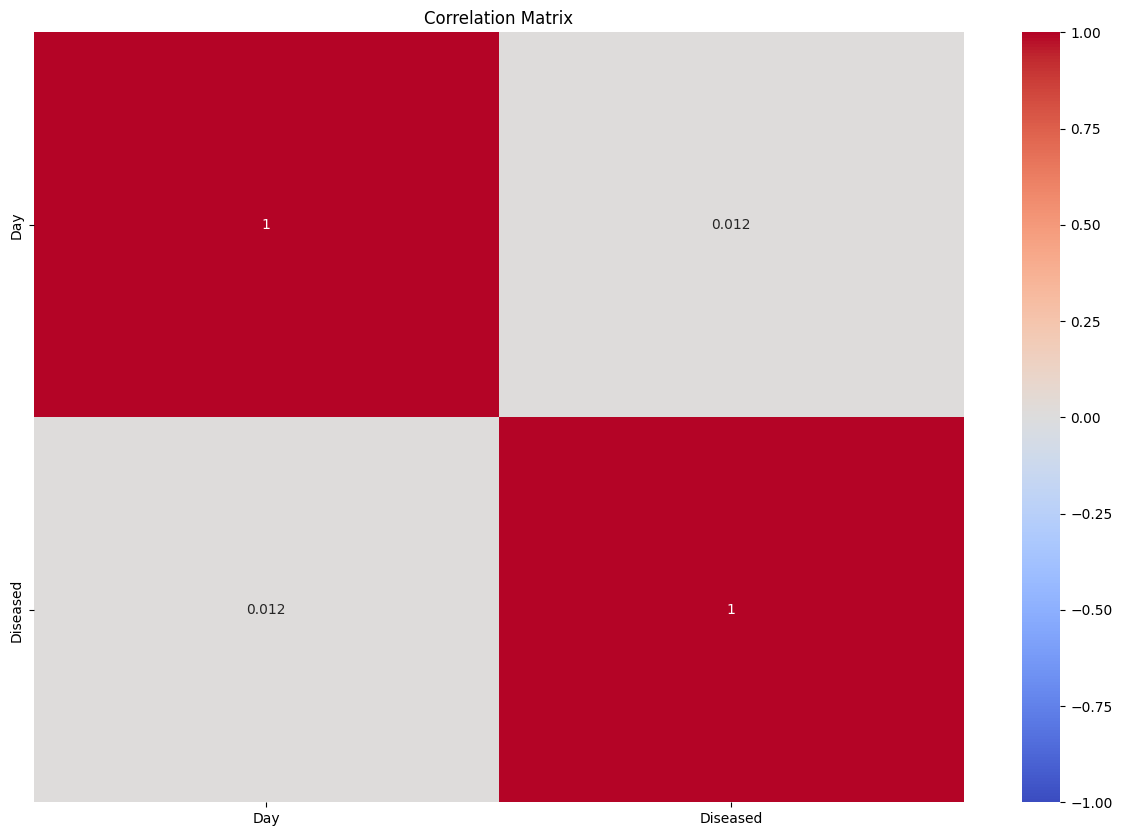

In [70]:
# heatmap of Day

plt.figure(figsize=(15, 10))

sns.heatmap(train[['Day', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

<Axes: xlabel='Day', ylabel='Diseased'>

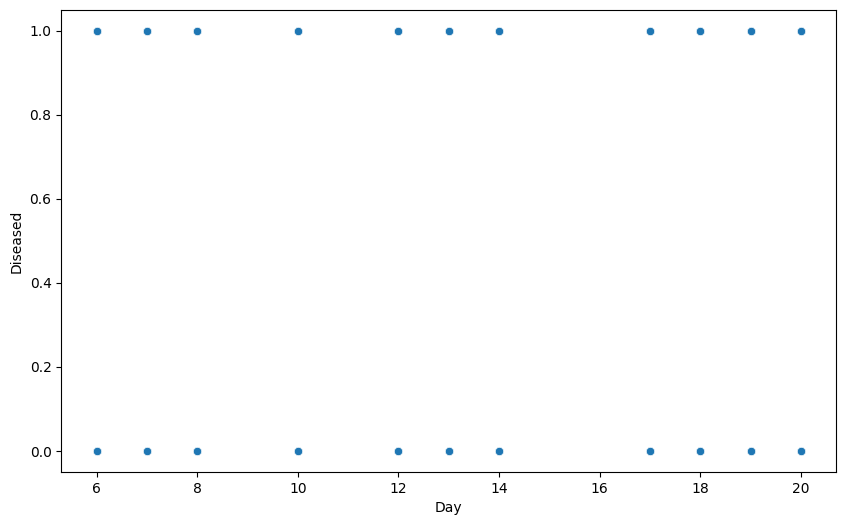

In [71]:

# scatterplot of day and Diseased

plt.figure(figsize=(10, 6))

sns.scatterplot(data=train, x='Day', y='Diseased')

In [72]:
# break up first half of month and second half of month

train['First_Half'] = train['Day'].apply(lambda x: 1 if x <= 15 else 0)

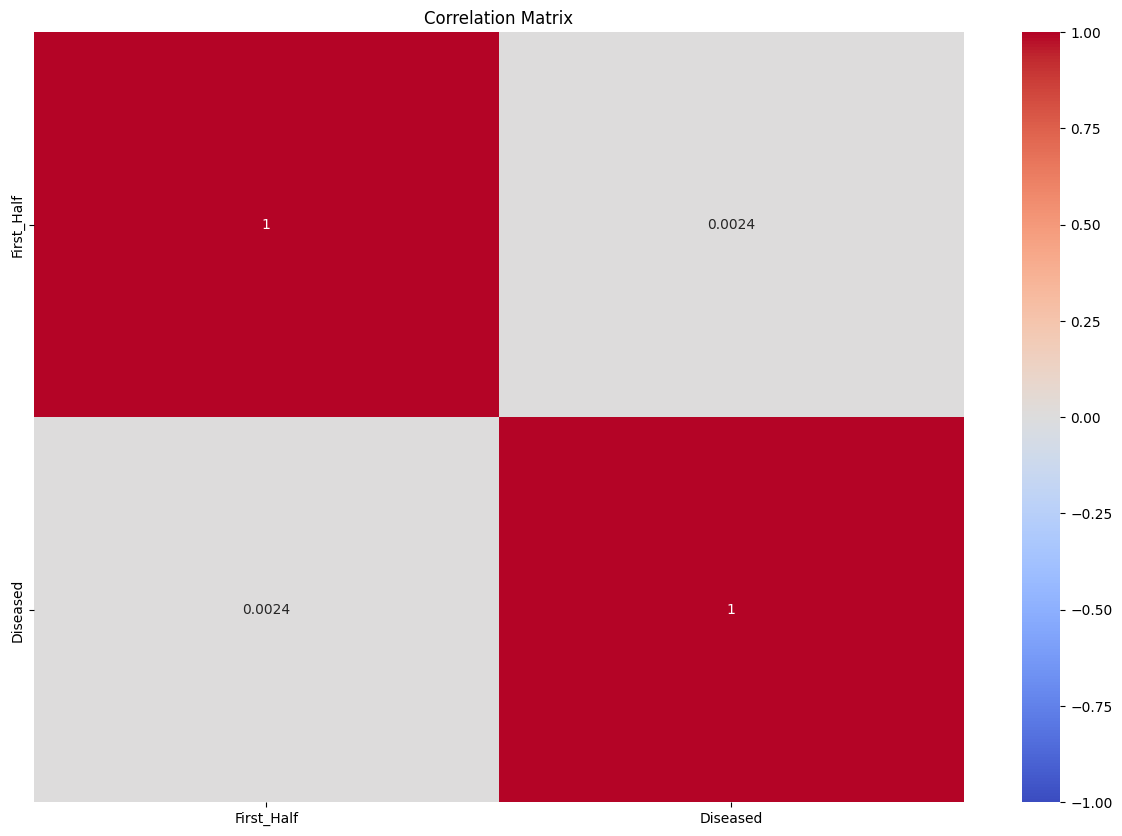

In [73]:
# heatmap of First_Half

plt.figure(figsize=(15, 10))

sns.heatmap(train[['First_Half', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Hectare Squirrel Number'}>,
        <Axes: title={'center': 'Running'}>,
        <Axes: title={'center': 'Chasing'}>,
        <Axes: title={'center': 'Climbing'}>],
       [<Axes: title={'center': 'Eating'}>,
        <Axes: title={'center': 'Foraging'}>,
        <Axes: title={'center': 'Kuks'}>,
        <Axes: title={'center': 'Quaas'}>,
        <Axes: title={'center': 'Moans'}>,
        <Axes: title={'center': 'Tail flags'}>,
        <Axes: title={'center': 'Tail twitches'}>],
       [<Axes: title={'center': 'Approaches'}>,
        <Axes: title={'center': 'Indifferent'}>,
        <Axes: title={'center': 'Runs from'}>,
        <Axes: title={'center': 'Time'}>,
        <Axes: title={'center': 'Temperature (°F) Max'}>,
        <Axes: title={'center': 'Temperature (°F) Avg'}>,
        <Axes: title={'center': 'Temperature (°F) Min'}>],
       [<Ax

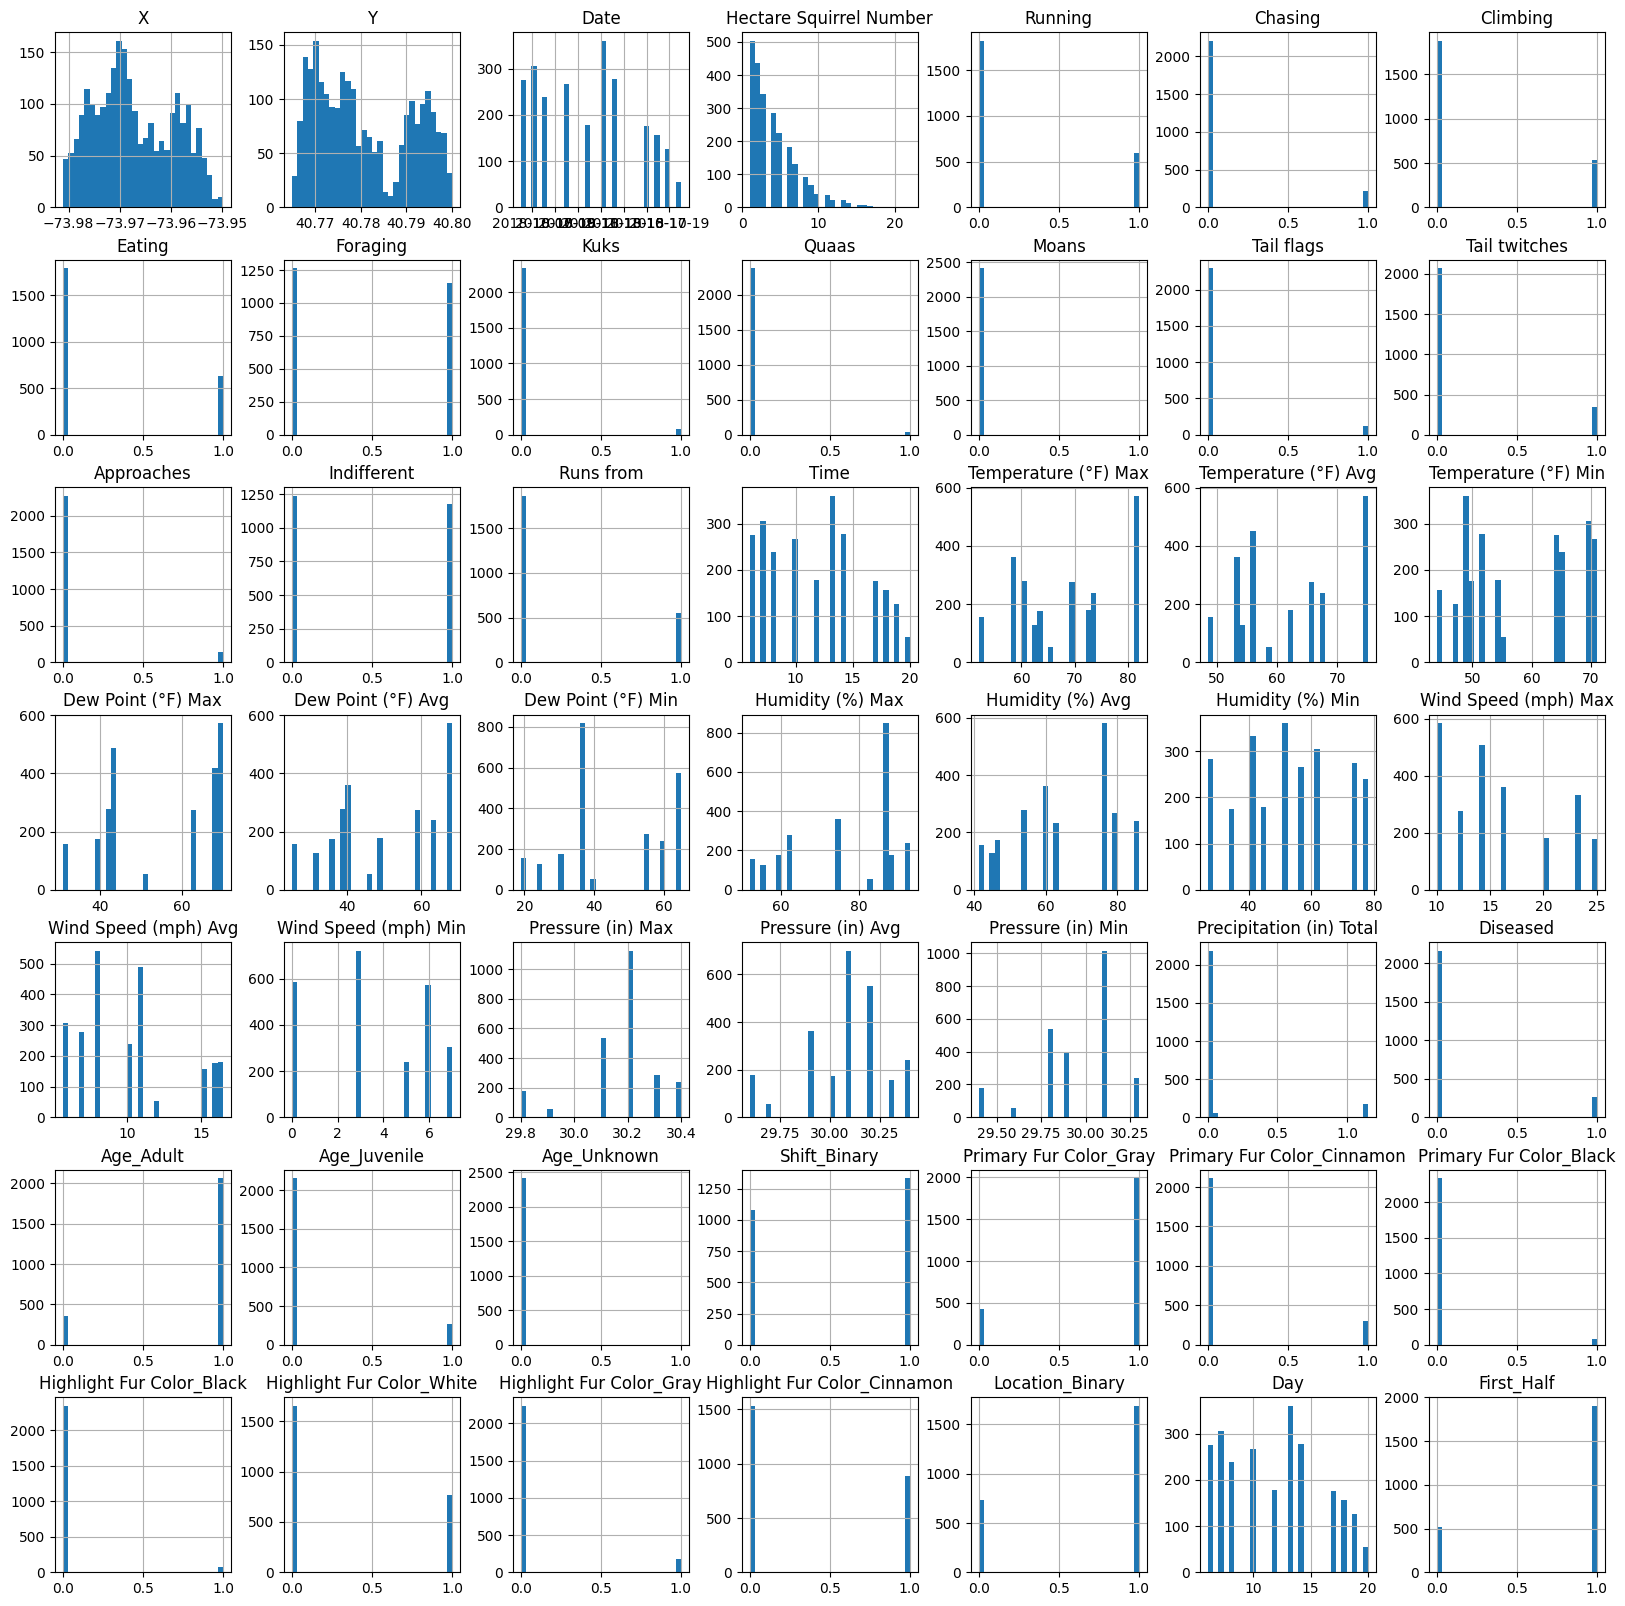

In [74]:
#histogram of train

train.hist(figsize=(20, 20), bins=30)

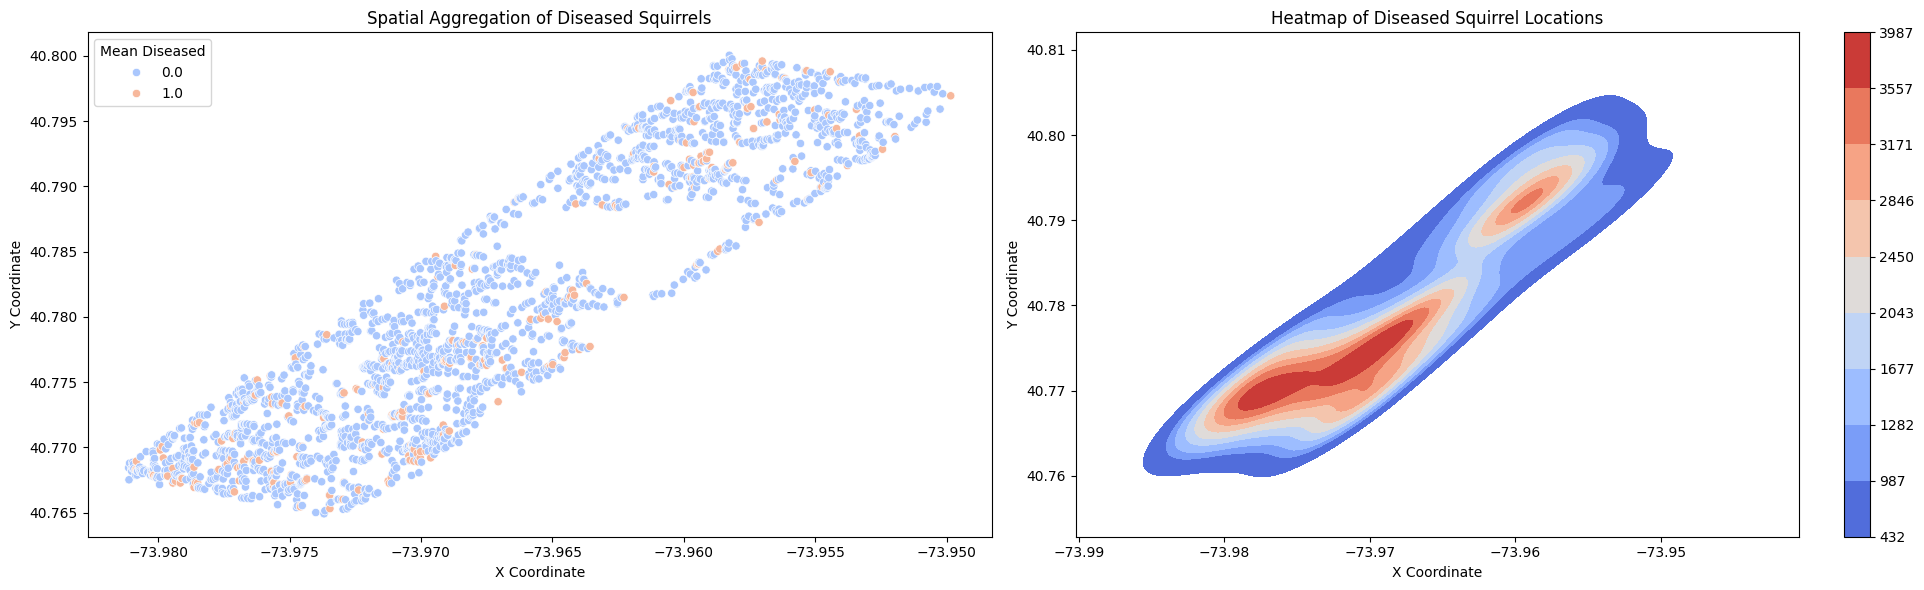

In [75]:
# Group by spatial coordinates and calculate the mean of the target label
spatial_aggregation = train.groupby(['X', 'Y'])['Diseased'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the spatial aggregation to visualize the correlation
sns.scatterplot(data=spatial_aggregation, x='X', y='Y', hue='Diseased', palette='coolwarm', legend='full', ax=axes[0])
axes[0].set_title('Spatial Aggregation of Diseased Squirrels')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].legend(title='Mean Diseased')

# Filter the data to include only diseased squirrels
diseased_squirrels = train[train['Diseased'] == 1]

# Create a heatmap of the locations of diseased squirrels
sns.kdeplot(data=diseased_squirrels, x='X', y='Y', fill=True, cmap='coolwarm', cbar=True, ax=axes[1])
axes[1].set_title('Heatmap of Diseased Squirrel Locations')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

# Spatial Analysis of Diseased Squirrels

This visualization consists of two plots that aim to explore the spatial distribution of diseased squirrels in the dataset and identify any potential spatial patterns.

## Left Plot: Spatial Aggregation of Diseased Squirrels
- **Description**: This scatter plot represents squirrel sightings, with each point corresponding to a sighting's coordinates (`X`, `Y`).
- **Color Code**: Squirrels are color-coded based on the `Diseased` label:
  - **0 (Blue)**: Represents healthy squirrels.
  - **1 (Orange)**: Represents diseased squirrels.
- **Purpose**: By aggregating the sightings based on the `Diseased` status, this plot helps in identifying any clusters or high-density areas where diseased squirrels are prevalent.

## Right Plot: Heatmap of Diseased Squirrel Locations
- **Description**: This heatmap focuses specifically on the locations of diseased squirrels.
- **Color Gradient**: Indicates the density of diseased squirrel sightings:
  - **Red areas**: High density of diseased squirrel sightings.
  - **Blue areas**: Low density of diseased squirrel sightings.
- **Purpose**: The heatmap provides a smoother view of spatial density, helping to visually highlight areas with a higher prevalence of diseased squirrels.

## Insights
- The comparison between the scatter plot and heatmap allows for a deeper understanding of the spatial distribution of diseased squirrels.
- The density-based color gradient in the heatmap may help identify hotspot areas with a higher concentration of diseased sightings, which could be useful for further analysis, clustering, or targeted disease management.

In [76]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Extract the coordinates of diseased squirrels
diseased_coords = train[train['Diseased'] == 1][['X', 'Y']].values

# Use DBSCAN to identify clusters of diseased squirrels
dbscan = DBSCAN(eps=0.0002, min_samples=2)
diseased_clusters = dbscan.fit_predict(diseased_coords)

# Get the coordinates of the cluster centers
cluster_centers = []
for cluster in set(diseased_clusters):
    if cluster != -1:  # Ignore noise points
        cluster_points = diseased_coords[diseased_clusters == cluster]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)

cluster_centers = np.array(cluster_centers)

# Calculate the distance from each squirrel to the nearest diseased squirrel cluster
nbrs = NearestNeighbors(n_neighbors=1).fit(cluster_centers)
distances, _ = nbrs.kneighbors(train[['X', 'Y']].values)

# Create the 'hotspots' feature based on the distances
train['hotspots'] = distances

### `hotspots` Feature Documentation

The `hotspots` feature represents the **distance from each squirrel to the nearest center of a cluster of diseased squirrels**. Here’s a breakdown of how this feature is generated and what it measures:

1. **Clustering Diseased Squirrels**:
   - Using DBSCAN (Density-Based Spatial Clustering of Applications with Noise), clusters of diseased squirrels are identified based on their `X` and `Y` coordinates.
   - DBSCAN parameters (`eps=0.001` and `min_samples=2`) specify that squirrels within a close range form a cluster if there are at least two squirrels in proximity. Any points that don’t meet these parameters are labeled as noise and ignored in cluster center calculations.

2. **Calculating Cluster Centers**:
   - For each diseased cluster identified by DBSCAN, the mean of the `X` and `Y` coordinates of squirrels within the cluster is calculated. This mean point serves as the **center of the diseased cluster**, representing the geographical center of the area with a high concentration of diseased squirrels.

3. **Determining Distance to Nearest Cluster Center**:
   - Using the `NearestNeighbors` algorithm, the distance from each squirrel (in the entire dataset) to the closest diseased cluster center is computed.
   - These distance values are stored in the `hotspots` feature, capturing each squirrel’s proximity to the nearest center of a diseased cluster.

### Interpretation of `hotspots`
- **Small `hotspots` Value**: Indicates that a squirrel is close to the center of a diseased cluster, suggesting a higher potential for exposure to diseased squirrels.
- **Large `hotspots` Value**: Indicates that a squirrel is far from any diseased clusters, suggesting a lower likelihood of exposure.

In summary, the `hotspots` feature quantifies each squirrel’s proximity to high-density areas of diseased squirrels, making it a possible risk indicator for disease exposure based on spatial closeness.


      hotspots_distance  hotspots_inverse  hotspots_log
1403           0.000405       2471.848997     -7.812722
2648           0.001616        618.722925     -6.427658
1374           0.002400        416.609052     -6.032148
548            0.000124       8093.754724     -8.998848
1897           0.000197       5084.556582     -8.533963


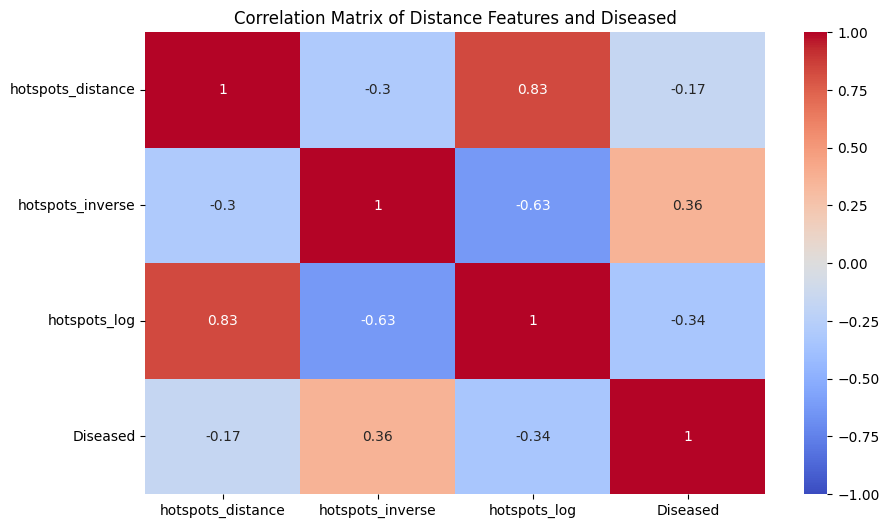

In [77]:
# Add the actual hotspots distance as a continuous feature
train['hotspots_distance'] = train['hotspots']

# Apply transformations
train['hotspots_inverse'] = 1 / train['hotspots']
train['hotspots_log'] = np.log(train['hotspots'])

# Display the first few rows to verify the new features
print(train[['hotspots_distance', 'hotspots_inverse', 'hotspots_log']].head())

# Calculate the correlation between the new features and 'Diseased'
distance_features = ['hotspots_distance', 'hotspots_inverse', 'hotspots_log']
correlation_distance_diseased = train[distance_features + ['Diseased']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_distance_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Distance Features and Diseased")
plt.show()

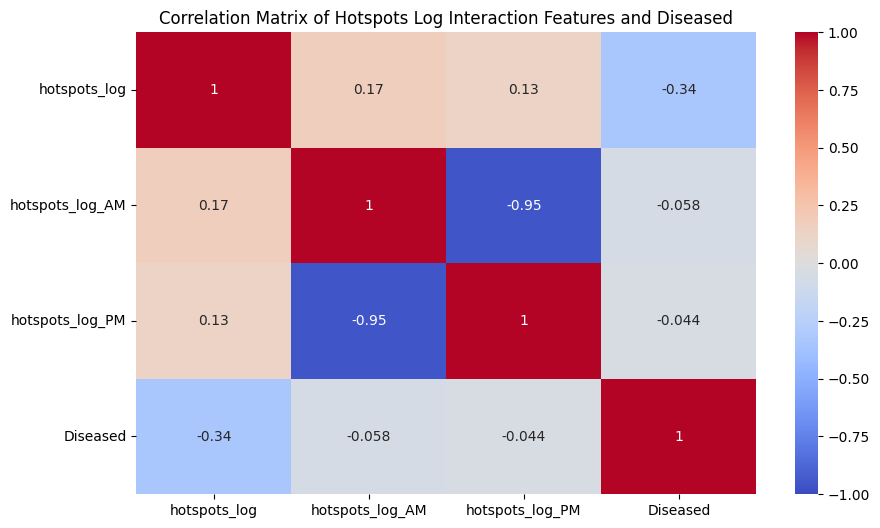

In [78]:
# Create new features for the interaction between hotspots_log and the shifts
train['hotspots_log_AM'] = train['hotspots_log'] * (train['Shift'] == 'AM').astype(int)
train['hotspots_log_PM'] = train['hotspots_log'] * (train['Shift'] == 'PM').astype(int)

# Calculate the correlation matrix including the new features and the Diseased feature
interaction_features = ['hotspots_log', 'hotspots_log_AM', 'hotspots_log_PM', 'Diseased']
correlation_interaction_diseased = train[interaction_features].corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_interaction_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Hotspots Log Interaction Features and Diseased")
plt.show()

bruh

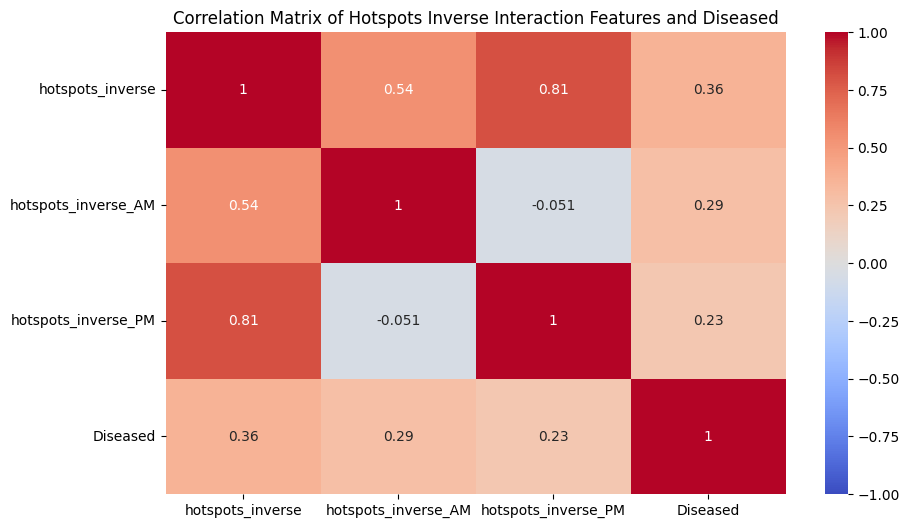

In [79]:
# Create new features for the interaction between hotspots_inverse and the shifts
train['hotspots_inverse_AM'] = train['hotspots_inverse'] * (train['Shift'] == 'AM').astype(int)
train['hotspots_inverse_PM'] = train['hotspots_inverse'] * (train['Shift'] == 'PM').astype(int)

# Calculate the correlation matrix including the new features and the Diseased feature
interaction_features = ['hotspots_inverse', 'hotspots_inverse_AM', 'hotspots_inverse_PM', 'Diseased']
correlation_interaction_diseased = train[interaction_features].corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_interaction_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Hotspots Inverse Interaction Features and Diseased")
plt.show()

so am and pm do have a positive correlation with the target label, using the inverse of hotspots. 

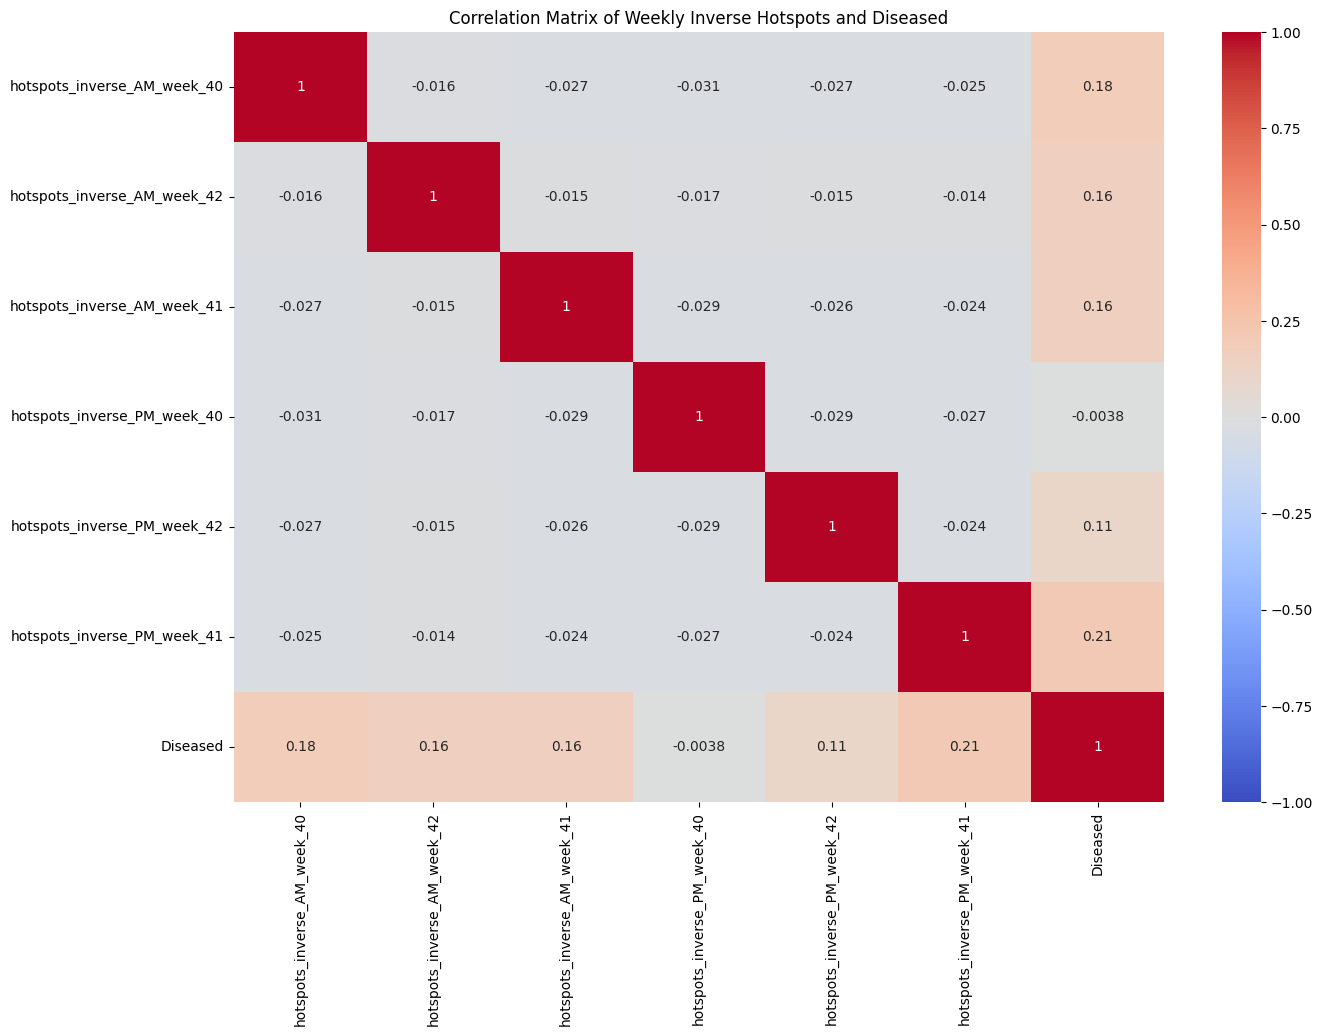

In [80]:
# Create 'Week' column from 'Date' column
train['Week'] = train['Date'].dt.isocalendar().week

# Create new features for the interaction between weekly hotspots_inverse and the shifts
for week in train['Week'].unique():
    train[f'hotspots_inverse_AM_week_{week}'] = train.apply(lambda x: x['hotspots_inverse'] if x['Shift'] == 'AM' and x['Week'] == week else 0, axis=1)
    train[f'hotspots_inverse_PM_week_{week}'] = train.apply(lambda x: x['hotspots_inverse'] if x['Shift'] == 'PM' and x['Week'] == week else 0, axis=1)

# Calculate the correlation matrix including the new weekly features and the Diseased feature
weekly_features = [f'hotspots_inverse_AM_week_{week}' for week in train['Week'].unique()] + [f'hotspots_inverse_PM_week_{week}' for week in train['Week'].unique()] + ['Diseased']
correlation_weekly_diseased = train[weekly_features].corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_weekly_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Weekly Inverse Hotspots and Diseased")
plt.show()

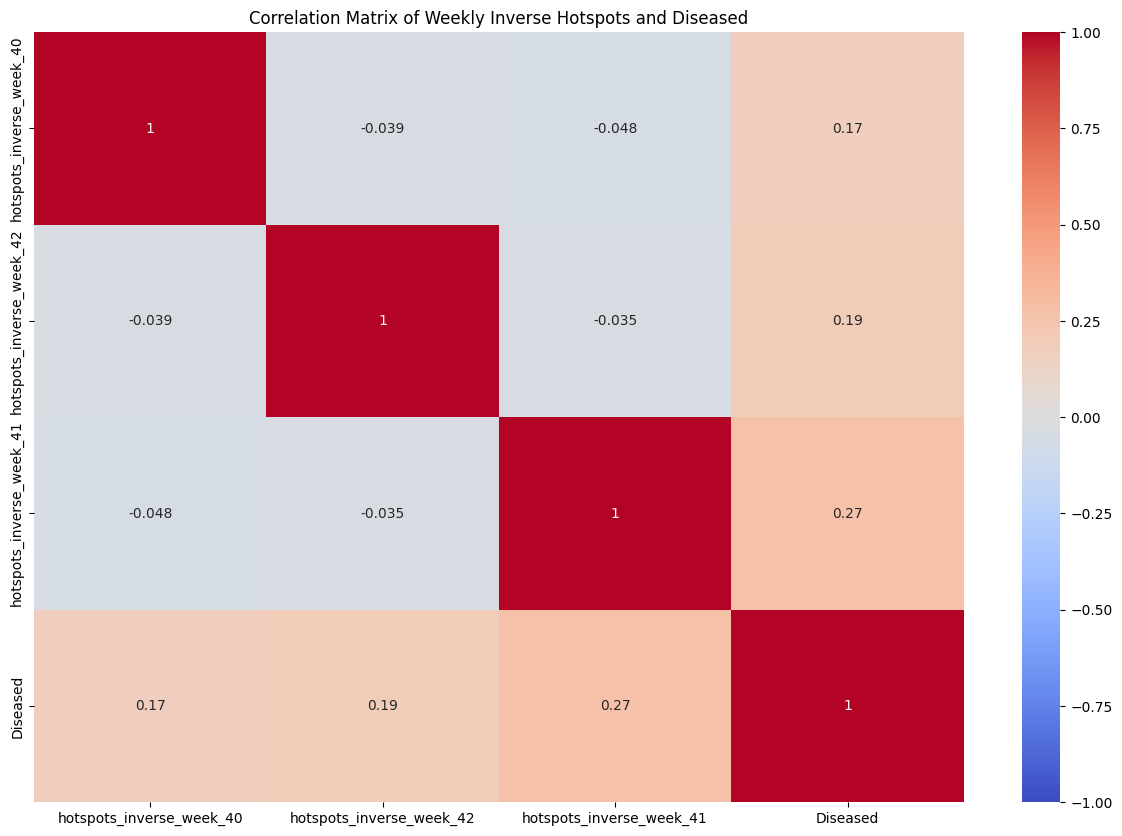

In [81]:
# Create new features for the interaction between hotspots_inverse and the weeks
for week in train['Week'].unique():
    train[f'hotspots_inverse_week_{week}'] = train.apply(lambda x: x['hotspots_inverse'] if x['Week'] == week else 0, axis=1)

# Calculate the correlation matrix including the new weekly features and the Diseased feature
weekly_features = [f'hotspots_inverse_week_{week}' for week in train['Week'].unique()] + ['Diseased']
correlation_weekly_diseased = train[weekly_features].corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_weekly_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Weekly Inverse Hotspots and Diseased")
plt.show()

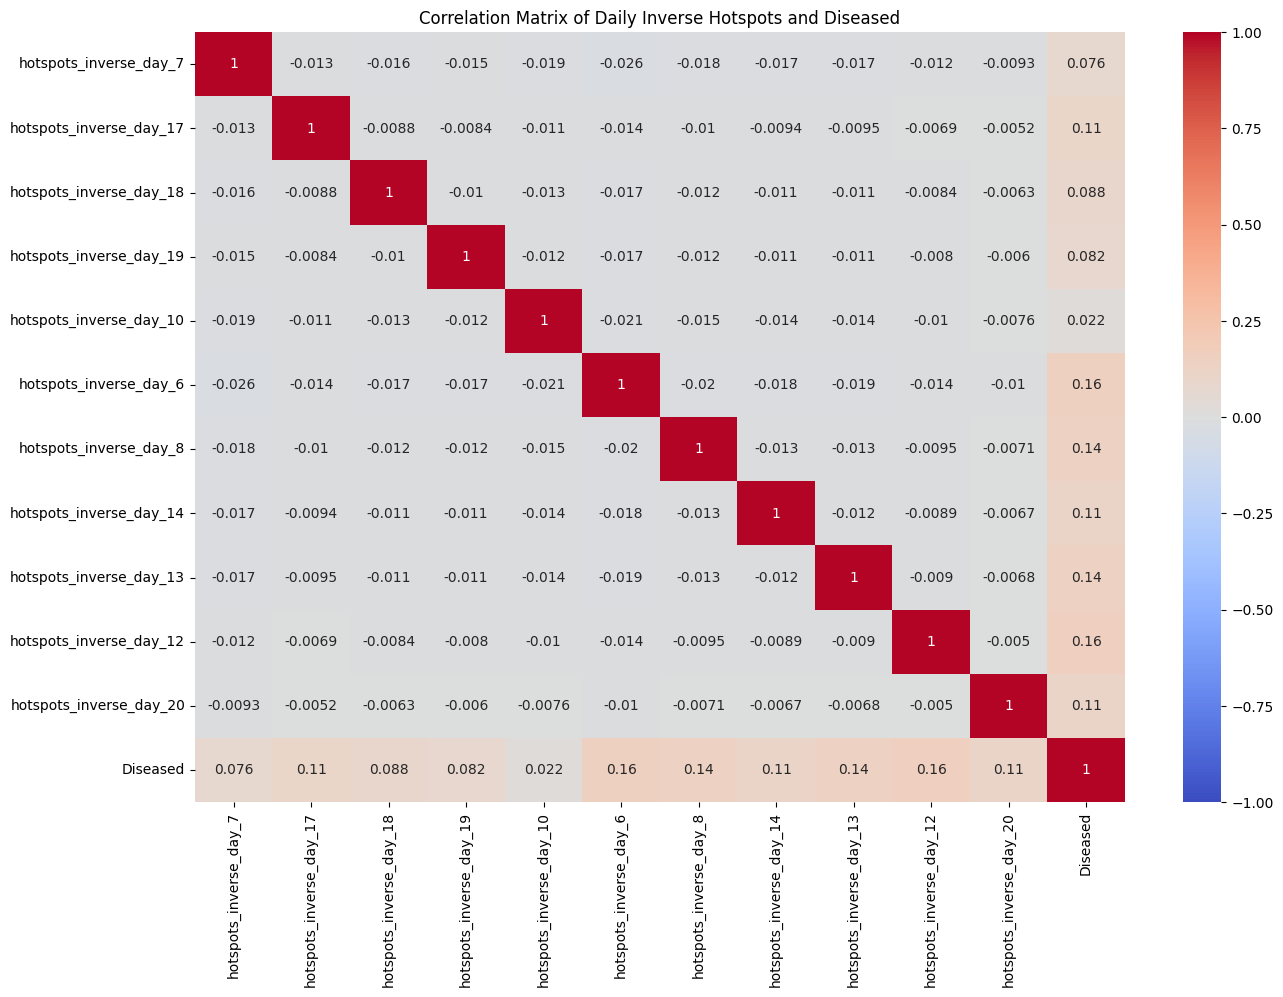

In [82]:
# Create new features for the interaction between hotspots_inverse and the days
for day in train['Day'].unique():
    train[f'hotspots_inverse_day_{day}'] = train.apply(lambda x: x['hotspots_inverse'] if x['Day'] == day else 0, axis=1)

# Calculate the correlation matrix including the new daily features and the Diseased feature
daily_features = [f'hotspots_inverse_day_{day}' for day in train['Day'].unique()] + ['Diseased']
correlation_daily_diseased = train[daily_features].corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_daily_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Inverse Hotspots and Diseased")
plt.show()

      within_9e-05  within_0.0002  within_0.002  within_0.005
1403             0              0             1             1
2648             0              0             1             1
1374             0              0             0             1
548              0              1             1             1
1897             0              1             1             1


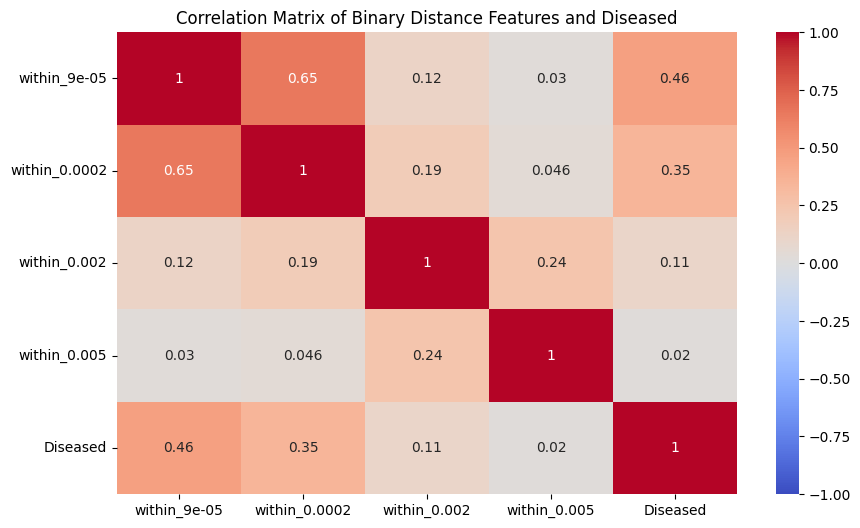

In [83]:
# Define the distance thresholds
distance_thresholds = [0.00009, 0.0002, 0.002, 0.005]

# Create binary features for each distance threshold
for threshold in distance_thresholds:
    train[f'within_{threshold}'] = (train['hotspots_distance'] <= threshold).astype(int)

# Display the first few rows to verify the new features
print(train[[f'within_{threshold}' for threshold in distance_thresholds]].head())

# Calculate the correlation between the new binary features and 'Diseased'
binary_distance_features = [f'within_{threshold}' for threshold in distance_thresholds]
correlation_binary_distance_diseased = train[binary_distance_features + ['Diseased']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_binary_distance_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Binary Distance Features and Diseased")
plt.show()

Correlation between 'hotspots' and 'Diseased': -0.17021894464186368


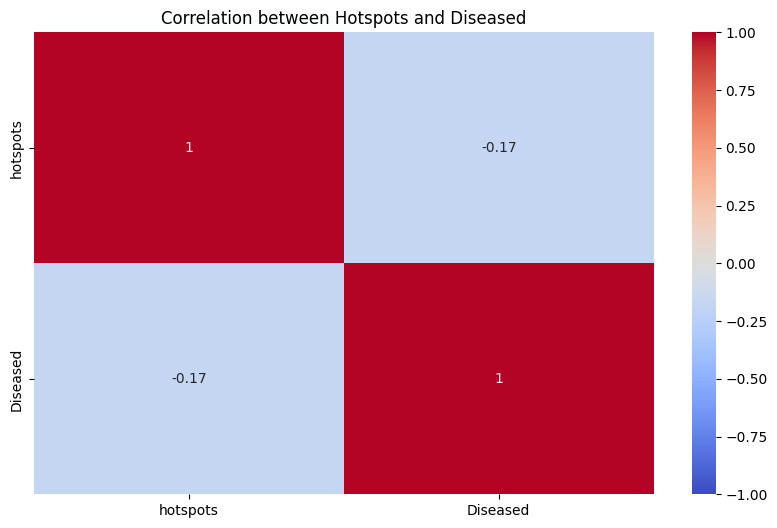

In [84]:
# Calculate the correlation between 'hotspots' and 'Diseased' in the train data
correlation = train['hotspots'].corr(train['Diseased'])

print(f"Correlation between 'hotspots' and 'Diseased': {correlation}")
# Create a heatmap to visualize the correlation between 'hotspots' and 'Diseased'
plt.figure(figsize=(10, 6))
sns.heatmap(train[['hotspots', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Hotspots and Diseased')
plt.show()

In [85]:
# Define the quantiles for the hotspots
high_threshold = train['hotspots_inverse'].quantile(0.75)
low_threshold = train['hotspots_inverse'].quantile(0.25)

# Create a new column 'hotspot_category' based on the thresholds
train['hotspot_inverse_category'] = pd.cut(train['hotspots_inverse'], bins=[-float('inf'), low_threshold, high_threshold, float('inf')], labels=['Low', 'Medium', 'High'])

# Display the value counts for each category
print(train['hotspot_inverse_category'].value_counts())

hotspot_inverse_category
Medium    1208
Low        605
High       605
Name: count, dtype: int64


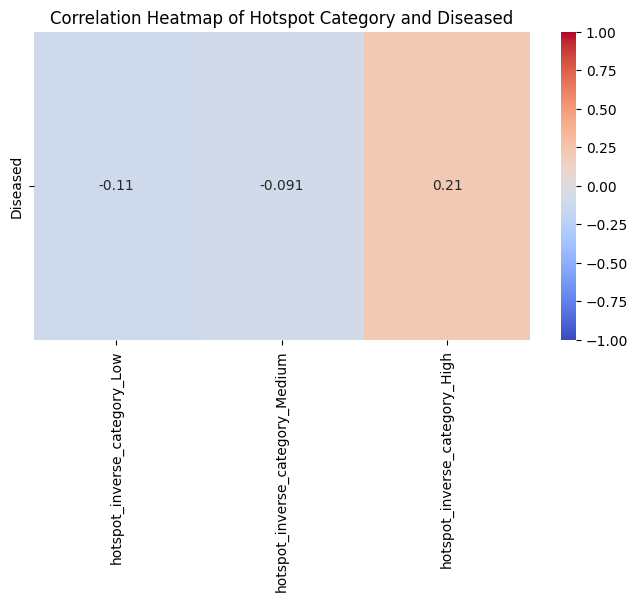

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# One-hot encode the 'hotspot_category' feature
hotspot_dummies = pd.get_dummies(train['hotspot_inverse_category'], prefix='hotspot_inverse_category')

# Concatenate the dummy variables with the original DataFrame
data_with_dummies = pd.concat([train, hotspot_dummies], axis=1)

# Calculate the correlation matrix with the 'Diseased' target
correlation_matrix = data_with_dummies[['Diseased'] + list(hotspot_dummies.columns)].corr()

# Extract only the rows related to 'Diseased' for the heatmap
correlation_with_diseased = correlation_matrix.loc[['Diseased'], hotspot_dummies.columns]

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_with_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Hotspot Category and Diseased")
plt.show()


There seems to be correlation with Low and High

In [87]:
# Create a new column 'Temperature Range' by subtracting the minimum temperature from the maximum temperature
train['Temperature Range'] = train['Temperature (°F) Max'] - train['Temperature (°F) Min']

train[['Temperature (°F) Max', 'Temperature (°F) Min', 'Temperature Range']]

Temperature (°F) Max  Temperature (°F) Min  Temperature Range
1403                    81                    70                 11
2648                    63                    50                 13
1374                    63                    50                 13
548                     52                    44                  8
1897                    62                    47                 15
...                    ...                   ...                ...
1978                    60                    52                  8
493                     81                    70                 11
132                     81                    70                 11
1556                    69                    64                  5
1006                    52                    44                  8

[2418 rows x 3 columns]

Correlation between 'Temperature Range' and 'Diseased': 0.0029654325980799892


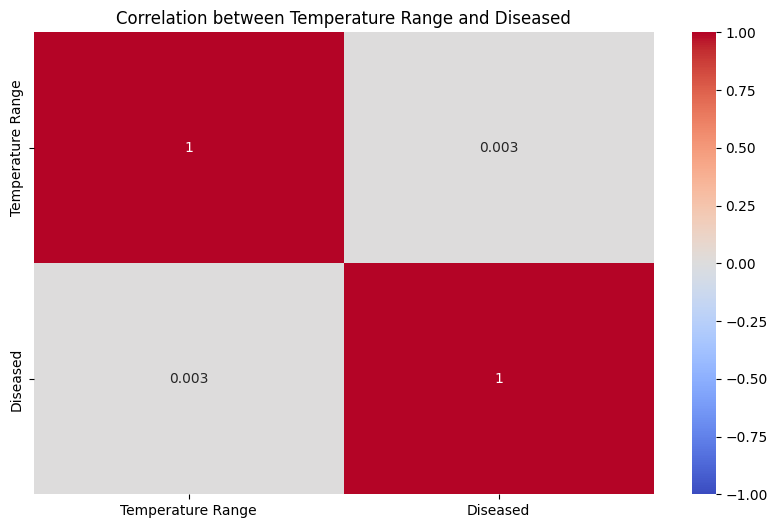

In [88]:
correlation_temp_range_diseased = train['Temperature Range'].corr(train['Diseased'])
print(f"Correlation between 'Temperature Range' and 'Diseased': {correlation_temp_range_diseased}")
plt.figure(figsize=(10, 6))
sns.heatmap(train[['Temperature Range', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Temperature Range and Diseased')
plt.show()

In [89]:
# Create a new feature 'Temp_Humidity' by multiplying average temperature and average humidity
train['Temp_Humidity'] = train['Temperature (°F) Avg'] * train['Humidity (%) Avg']

# Display the first few rows to verify the new feature
train[['Temperature (°F) Avg', 'Humidity (%) Avg', 'Temp_Humidity']]


Temperature (°F) Avg  Humidity (%) Avg  Temp_Humidity
1403                  74.7              77.0        5751.90
2648                  55.8              46.8        2611.44
1374                  55.8              46.8        2611.44
548                   48.5              41.2        1998.20
1897                  54.3              44.5        2416.35
...                    ...               ...            ...
1978                  55.8              53.3        2974.14
493                   74.7              77.0        5751.90
132                   74.7              77.0        5751.90
1556                  66.1              76.8        5076.48
1006                  48.5              41.2        1998.20

[2418 rows x 3 columns]

Correlation between 'Temp_Humidity' and 'Diseased': -0.03596525960783276


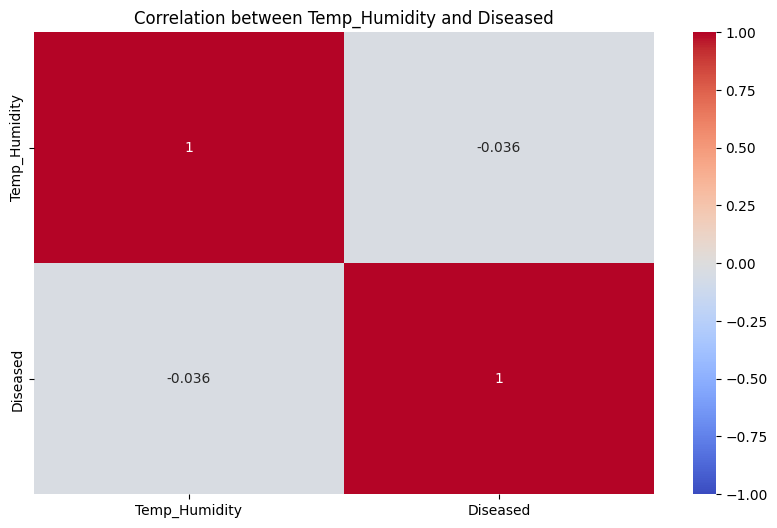

In [90]:
# Calculate the correlation between 'Temp_Humidity' and 'Diseased'
correlation_temp_humidity_diseased = train['Temp_Humidity'].corr(train['Diseased'])

print(f"Correlation between 'Temp_Humidity' and 'Diseased': {correlation_temp_humidity_diseased}")

# Create a heatmap to visualize the correlation between 'Temp_Humidity' and 'Diseased'
plt.figure(figsize=(10, 6))
sns.heatmap(train[['Temp_Humidity', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Temp_Humidity and Diseased')
plt.show()

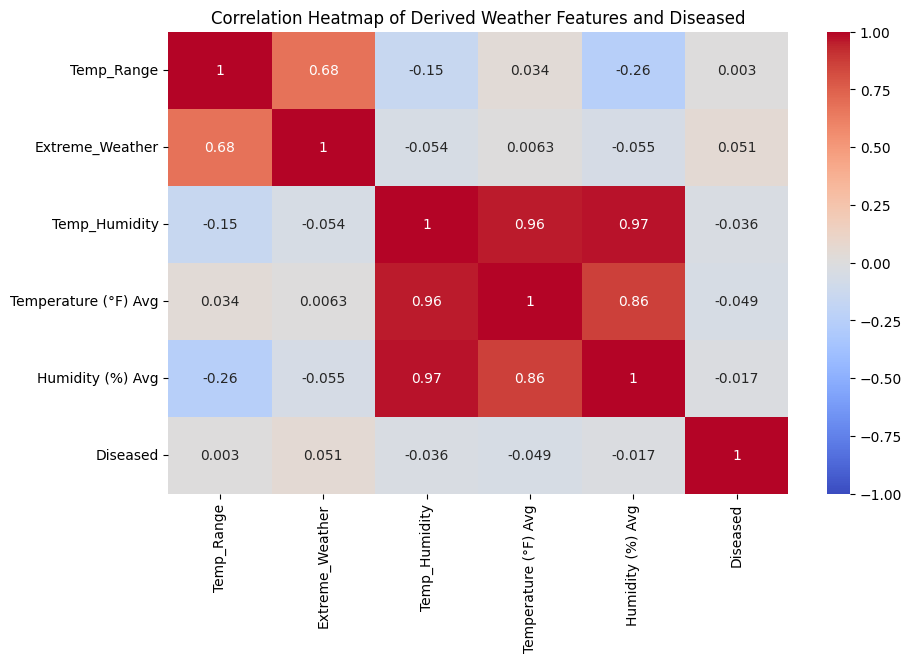

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Derived features
train['Temp_Range'] = train['Temperature (°F) Max'] - train['Temperature (°F) Min']
train['Extreme_Weather'] = ((train['Temperature (°F) Max'] > 85) | (train['Temperature (°F) Min'] < 30) | (train['Precipitation (in) Total'] > 1)).astype(int)
train['Temp_Humidity'] = train['Temperature (°F) Avg'] * train['Humidity (%) Avg']
train['Temp_Category'] = pd.cut(train['Temperature (°F) Avg'], bins=[-float('inf'), 50, 70, 90, float('inf')], labels=['Cold', 'Moderate', 'Warm', 'Hot'])

# Calculate correlations with the target label
weather_features = ['Temp_Range', 'Extreme_Weather', 'Temp_Humidity', 'Temperature (°F) Avg', 'Humidity (%) Avg']
correlations = train[weather_features + ['Diseased']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Derived Weather Features and Diseased")
plt.show()


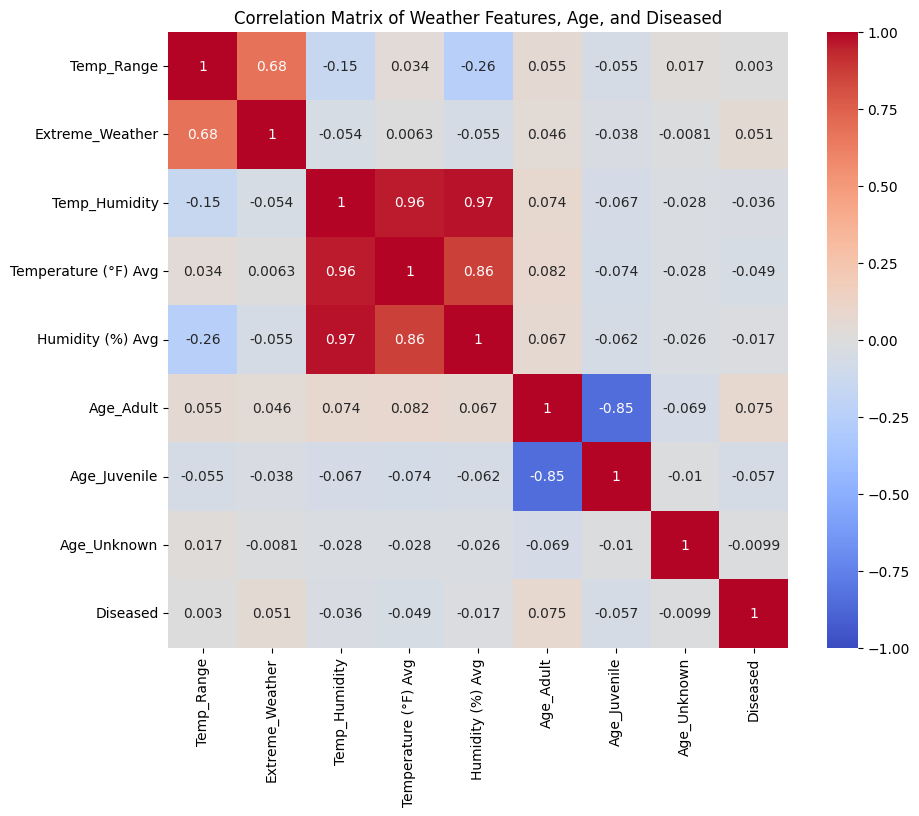

In [92]:
# Select the relevant features
features = ['Temp_Range', 'Extreme_Weather', 'Temp_Humidity', 'Temperature (°F) Avg', 'Humidity (%) Avg', 'Age_Adult', 'Age_Juvenile', 'Age_Unknown']

# Create a new DataFrame with the selected features and the target variable
combined_features = train[features + ['Diseased']]

# Calculate the correlation matrix
correlation_matrix = combined_features.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Weather Features, Age, and Diseased")
plt.show()

           X          Y Hectare Shift       Date  Hectare Squirrel Number  \
0 -73.970067  40.774286     12F    PM 2018-10-07                        8   
1 -73.970643  40.776293     13E    AM 2018-10-17                        7   
2 -73.956474  40.793885     36F    AM 2018-10-17                        3   
3 -73.964383  40.781545     21F    PM 2018-10-18                        3   
4 -73.971074  40.772327     10F    PM 2018-10-19                        7   

     Age Primary Fur Color Highlight Fur Color  \
0  Adult              Gray            Cinnamon   
1  Adult              Gray            Cinnamon   
2  Adult              Gray            Cinnamon   
3  Adult              Gray            Cinnamon   
4  Adult              Gray            Cinnamon   

  Combination of Primary and Highlight Color            Color notes  \
0                              Gray+Cinnamon                    NaN   
1                              Gray+Cinnamon                    NaN   
2                      

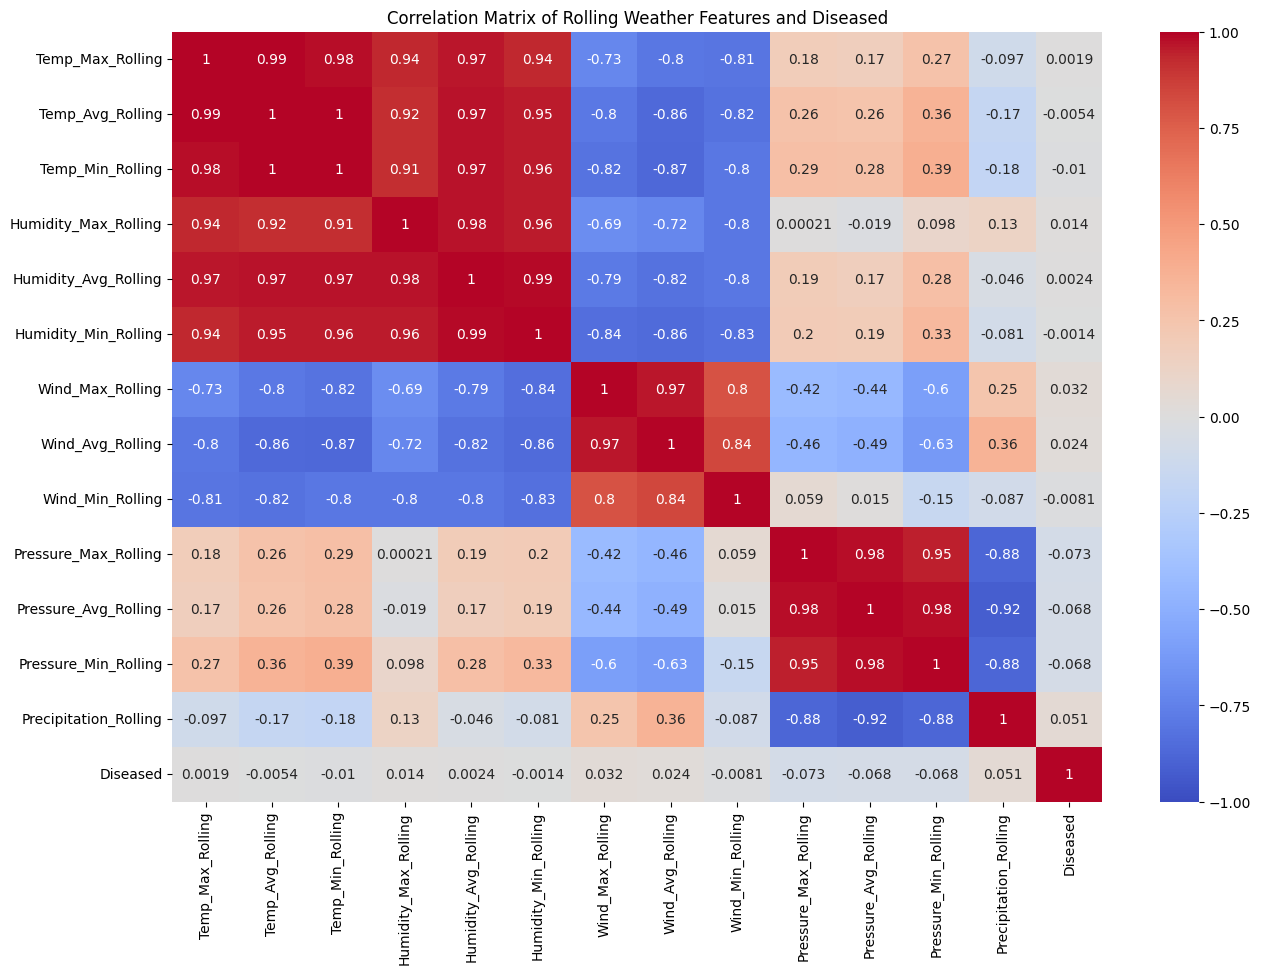

In [93]:
# Define the window size for rolling averages
window_size = 3

# Create rolling average features for weather data
weather['Temp_Max_Rolling'] = weather['Temperature (°F) Max'].rolling(window=window_size).mean()
weather['Temp_Avg_Rolling'] = weather['Temperature (°F) Avg'].rolling(window=window_size).mean()
weather['Temp_Min_Rolling'] = weather['Temperature (°F) Min'].rolling(window=window_size).mean()
weather['Humidity_Max_Rolling'] = weather['Humidity (%) Max'].rolling(window=window_size).mean()
weather['Humidity_Avg_Rolling'] = weather['Humidity (%) Avg'].rolling(window=window_size).mean()
weather['Humidity_Min_Rolling'] = weather['Humidity (%) Min'].rolling(window=window_size).mean()
weather['Wind_Max_Rolling'] = weather['Wind Speed (mph) Max'].rolling(window=window_size).mean()
weather['Wind_Avg_Rolling'] = weather['Wind Speed (mph) Avg'].rolling(window=window_size).mean()
weather['Wind_Min_Rolling'] = weather['Wind Speed (mph) Min'].rolling(window=window_size).mean()
weather['Pressure_Max_Rolling'] = weather['Pressure (in) Max'].rolling(window=window_size).mean()
weather['Pressure_Avg_Rolling'] = weather['Pressure (in) Avg'].rolling(window=window_size).mean()
weather['Pressure_Min_Rolling'] = weather['Pressure (in) Min'].rolling(window=window_size).mean()
weather['Precipitation_Rolling'] = weather['Precipitation (in) Total'].rolling(window=window_size).mean()

# Merge the rolling weather data with the squirrel data
train = pd.merge(train, weather[['Date', 'Temp_Max_Rolling', 'Temp_Avg_Rolling', 'Temp_Min_Rolling', 'Humidity_Max_Rolling', 'Humidity_Avg_Rolling', 'Humidity_Min_Rolling', 'Wind_Max_Rolling', 'Wind_Avg_Rolling', 'Wind_Min_Rolling', 'Pressure_Max_Rolling', 'Pressure_Avg_Rolling', 'Pressure_Min_Rolling', 'Precipitation_Rolling']], on='Date', how='left')

# Display the first few rows of the updated dataframe
print(train.head())

# Calculate the correlation between the new rolling weather features and the 'Diseased' target
correlation_rolling_weather = train[['Temp_Max_Rolling', 'Temp_Avg_Rolling', 'Temp_Min_Rolling', 'Humidity_Max_Rolling', 'Humidity_Avg_Rolling', 'Humidity_Min_Rolling', 'Wind_Max_Rolling', 'Wind_Avg_Rolling', 'Wind_Min_Rolling', 'Pressure_Max_Rolling', 'Pressure_Avg_Rolling', 'Pressure_Min_Rolling', 'Precipitation_Rolling', 'Diseased']].corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_rolling_weather, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Rolling Weather Features and Diseased")
plt.show()

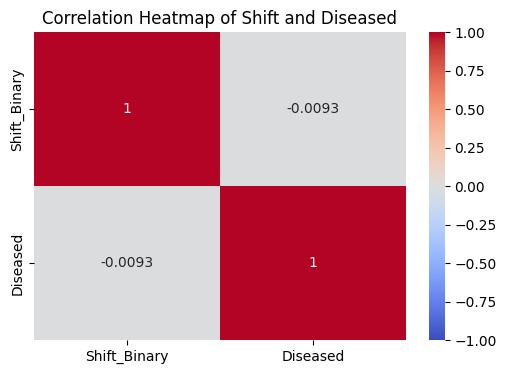

In [94]:
import seaborn as sns

import matplotlib.pyplot as plt

# Encode the 'Shift' column as a binary variable
train['Shift_Binary'] = train['Shift'].apply(lambda x: 1 if x == 'PM' else 0)

# Calculate the correlation matrix with the 'Diseased' target
correlation_matrix = train[['Shift_Binary', 'Diseased']].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Shift and Diseased")
plt.show()

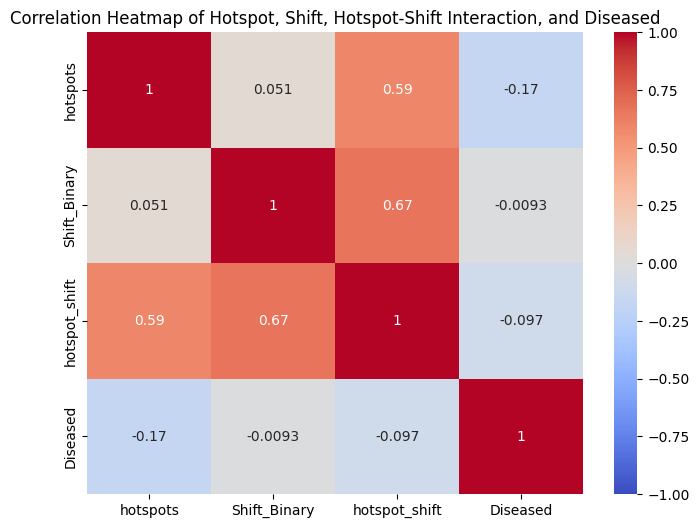

In [95]:
# Create a new feature that combines 'hotspot' and 'Shift'
train['hotspot_shift'] = train['hotspots'] * train['Shift_Binary']

# Calculate the correlation matrix including the new feature and the 'Diseased' label
correlation_matrix = train[['hotspots', 'Shift_Binary', 'hotspot_shift', 'Diseased']].corr()

# Plot the heatmap to visualize the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Hotspot, Shift, Hotspot-Shift Interaction, and Diseased")
plt.show()

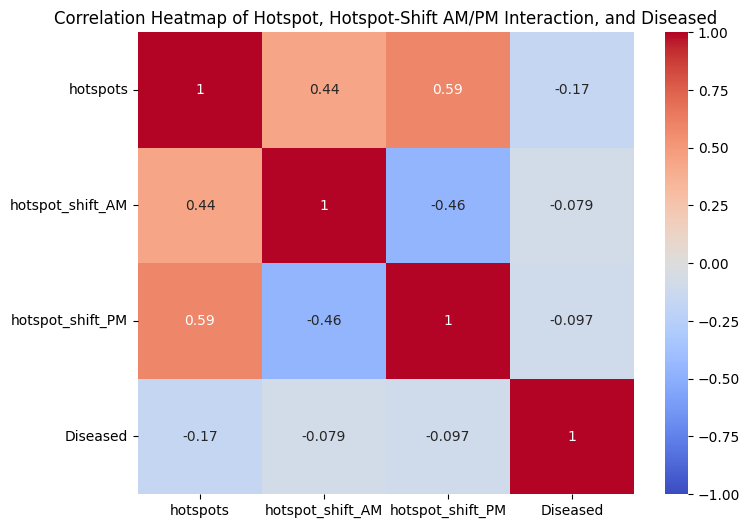

In [96]:
# Create new columns for hotspot_shift_AM and hotspot_shift_PM
train['hotspot_shift_AM'] = train['hotspots'] * (train['Shift_Binary'] == 0).astype(int)
train['hotspot_shift_PM'] = train['hotspots'] * (train['Shift_Binary'] == 1).astype(int)

# Calculate the correlation matrix including the new features and the 'Diseased' label
correlation_matrix = train[['hotspots', 'hotspot_shift_AM', 'hotspot_shift_PM', 'Diseased']].corr()

# Plot the heatmap to visualize the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Hotspot, Hotspot-Shift AM/PM Interaction, and Diseased")
plt.show()

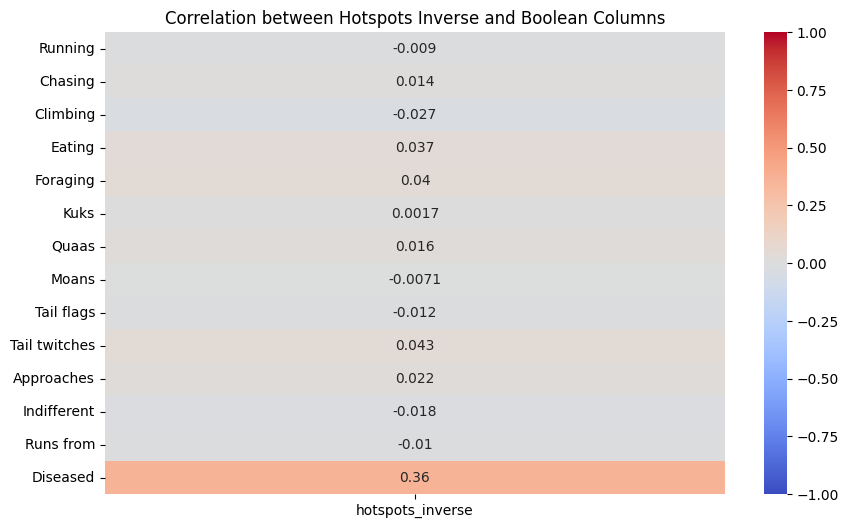

In [97]:
# Calculate the correlation between hotspots_inverse and boolean columns
boolean_columns = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from', 'Diseased']
correlation_hotspots_boolean = train[['hotspots_inverse'] + boolean_columns].corr()

# Extract the correlation of hotspots_inverse with boolean columns
correlation_hotspots_inverse = correlation_hotspots_boolean.loc['hotspots_inverse', boolean_columns]

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_hotspots_inverse.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between Hotspots Inverse and Boolean Columns")
plt.show()

In [99]:
train

X          Y Hectare Shift       Date  Hectare Squirrel Number  \
0    -73.970067  40.774286     12F    PM 2018-10-07                        8   
1    -73.970643  40.776293     13E    AM 2018-10-17                        7   
2    -73.956474  40.793885     36F    AM 2018-10-17                        3   
3    -73.964383  40.781545     21F    PM 2018-10-18                        3   
4    -73.971074  40.772327     10F    PM 2018-10-19                        7   
...         ...        ...     ...   ...        ...                      ...   
2413 -73.968664  40.784318     22B    PM 2018-10-14                        1   
2414 -73.954843  40.798207     41E    AM 2018-10-07                        6   
2415 -73.952868  40.792581     36I    PM 2018-10-07                       13   
2416 -73.974624  40.767149     03F    AM 2018-10-06                        6   
2417 -73.963532  40.782135     22G    AM 2018-10-18                        1   

           Age Primary Fur Color Highlight Fur Color  \
0        Adult              Gray            Cinnamon   
1        Adult              Gray            Cinnamon   
2        Adult              Gray            Cinnamon   
3        Adult              Gray            Cinnamon   
4        Adult              Gray            Cinnamon   
...        ...               ...                 ...   
2413  Juvenile              Gray            Cinnamon   
2414     Adult              Gray                       
2415     Adult              Gray            Cinnamon   
2416     Adult              Gray            Cinnamon   
2417     Adult              Gray            Cinnamon   

     Combination of Primary and Highlight Color  \
0                                 Gray+Cinnamon   
1                                 Gray+Cinnamon   
2                                 Gray+Cinnamon   
3                                 Gray+Cinnamon   
4                                 Gray+Cinnamon   
...                                         ...   
2413                              Gray+Cinnamon   
2414                                      Gray+   
2415                              Gray+Cinnamon   
2416                              Gray+Cinnamon   
2417                              Gray+Cinnamon   

                                            Color notes      Location  \
0                                                   NaN  Ground Plane   
1                                                   NaN  Ground Plane   
2                                 Cinnamon on shoulders  Ground Plane   
3                                                   NaN  Ground Plane   
4                                                   NaN  Above Ground   
...                                                 ...           ...   
2413                                                NaN  Ground Plane   
2414                                                NaN  Above Ground   
2415                                                NaN  Ground Plane   
2416  Gray & Cinnamon selected as Primary. Nothing s...  Ground Plane   
2417                                                NaN  Ground Plane   

     Above Ground Sighter Measurement  Specific Location  Running  Chasing  \
0                               FALSE                NaN        0        0   
1                               FALSE                NaN        0        0   
2                               FALSE                NaN        0        0   
3                               FALSE                NaN        0        0   
4                                  10  Same tree (as #6)        0        0   
...                               ...                ...      ...      ...   
2413                            FALSE                NaN        0        0   
2414                               30               tree        0        0   
2415                            FALSE                NaN        0        0   
2416                            FALSE                NaN        0        0   
2417                            

In [103]:
# List unique values in the 'Other Interactions' column
unique_other_interactions = train['Other Activities'].unique()
print(unique_other_interactions)


[nan 'did not notice dog sitting a few yards away (10-20 ft)'
 'together w/ #7' 'standing still' 'climbing (rock)' 'sitting'
 'chasing #7' 'chasing (chased by #1),found a nut,buried it'
 'got fed twice by grandpa,grabbed from grass and ate in tree' 'hopping'
 'jump' 'sitting in tree' 'with some nuts in the mouth'
 'standing on back legs' 'chasing (#4 across trees)' 'chasing #8'
 'climbing down' 'watching' 'walking' 'scratching' 'watching me'
 'hopping around grass' 'very quietly searching in long grass'
 'running (from a dog)' 'chasing (#3)' 'being chased'
 'eating (red berries)' 'chasing (#4)' 'nut in mouth' 'dead' 'playing'
 'not sure; walking-stop-walking-stop' 'ran across a path' 'burying'
 'climbed fence staring at me - went up tree' 'jumping on fence'
 'patting ground' 'not sure walk-pause-walk' 'drinking'
 'met #3 while foraging and briefly tussled' '2/3 were chasing each other'
 'gathering' 'burying nut' 'walking,exploring - digging in flower bed'
 'tumbling' 'chasing #2' 'bein

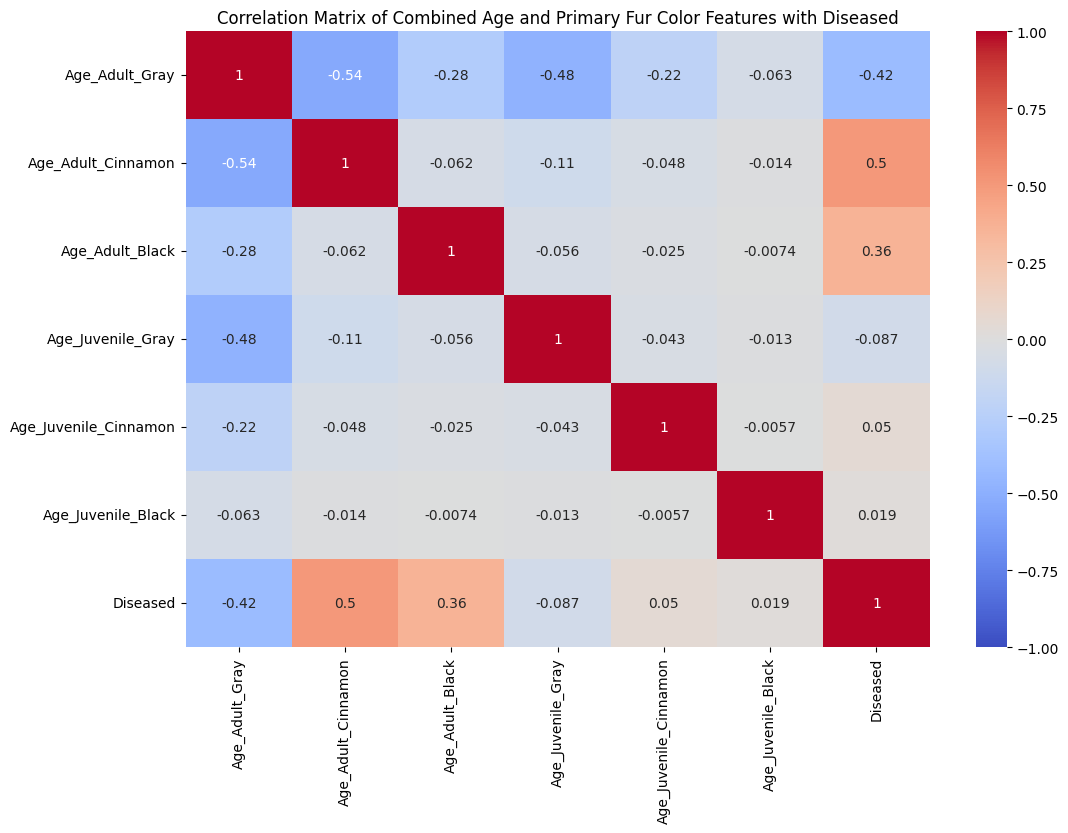

In [110]:
# Create new features by combining Age and Primary Fur Color
train['Age_Adult_Gray'] = train.apply(lambda x: 1 if x['Age'] == 'Adult' and x['Primary Fur Color'] == 'Gray' else 0, axis=1)
train['Age_Adult_Cinnamon'] = train.apply(lambda x: 1 if x['Age'] == 'Adult' and x['Primary Fur Color'] == 'Cinnamon' else 0, axis=1)
train['Age_Adult_Black'] = train.apply(lambda x: 1 if x['Age'] == 'Adult' and x['Primary Fur Color'] == 'Black' else 0, axis=1)
train['Age_Juvenile_Gray'] = train.apply(lambda x: 1 if x['Age'] == 'Juvenile' and x['Primary Fur Color'] == 'Gray' else 0, axis=1)
train['Age_Juvenile_Cinnamon'] = train.apply(lambda x: 1 if x['Age'] == 'Juvenile' and x['Primary Fur Color'] == 'Cinnamon' else 0, axis=1)
train['Age_Juvenile_Black'] = train.apply(lambda x: 1 if x['Age'] == 'Juvenile' and x['Primary Fur Color'] == 'Black' else 0, axis=1)

# List of new combined features
combined_features = [
    'Age_Adult_Gray', 'Age_Adult_Cinnamon', 'Age_Adult_Black',
    'Age_Juvenile_Gray', 'Age_Juvenile_Cinnamon', 'Age_Juvenile_Black'
]

# Calculate the correlation matrix including the new features and the Diseased feature
correlation_combined_diseased = train[combined_features + ['Diseased']].corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_combined_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Combined Age and Primary Fur Color Features with Diseased")
plt.show()

## Correlation Analysis of Combined Age and Primary Fur Color Features with Diseased Status

This analysis explores the correlation between various combinations of squirrel age, primary fur color, and the target label (`Diseased`). The purpose is to understand if particular combinations of age and fur color are associated with a higher likelihood of disease presence in the squirrel population. 

### Key Findings
- **Adult Gray Squirrels**: There is a negative correlation (-0.42) between `Age_Adult_Gray` and `Diseased`. This suggests that adult gray squirrels may have a lower likelihood of disease presence.
- **Adult Cinnamon Squirrels**: The `Age_Adult_Cinnamon` feature has a positive correlation (0.5) with `Diseased`, indicating that adult cinnamon squirrels may be more susceptible to disease.
- **Adult Black Squirrels**: This feature has a positive correlation (0.36) with `Diseased`, suggesting that adult black squirrels also show a higher likelihood of being diseased, though less than adult cinnamon squirrels.
- **Juvenile Gray Squirrels**: There is a negative correlation (-0.087) between `Age_Juvenile_Gray` and `Diseased`, indicating a minor tendency for juvenile gray squirrels to be less associated with disease.
- **Juvenile Cinnamon and Juvenile Black Squirrels**: Both `Age_Juvenile_Cinnamon` and `Age_Juvenile_Black` features have negligible correlations with `Diseased`, at 0.05 and 0.019 respectively, indicating little to no relationship between these juvenile colors and disease presence.


### Interpretation
- **Disease Risk by Fur Color**: Adult cinnamon and black squirrels show a higher correlation with disease, potentially making them key indicators of disease presence within the adult squirrel population.
- **Disease Resistance by Fur Color**: Adult gray squirrels exhibit a negative correlation, suggesting a lower association with disease presence. This finding could be useful in further investigating why this group shows potential disease resistance.
  
### Conclusion
Based on this correlation analysis, the `Age_Adult_Cinnamon` and `Age_Adult_Black` features may be useful predictors in the final model, as they show a stronger association with disease presence. Conversely, juvenile color-based features show minimal correlation and may not be significant predictors of disease status.

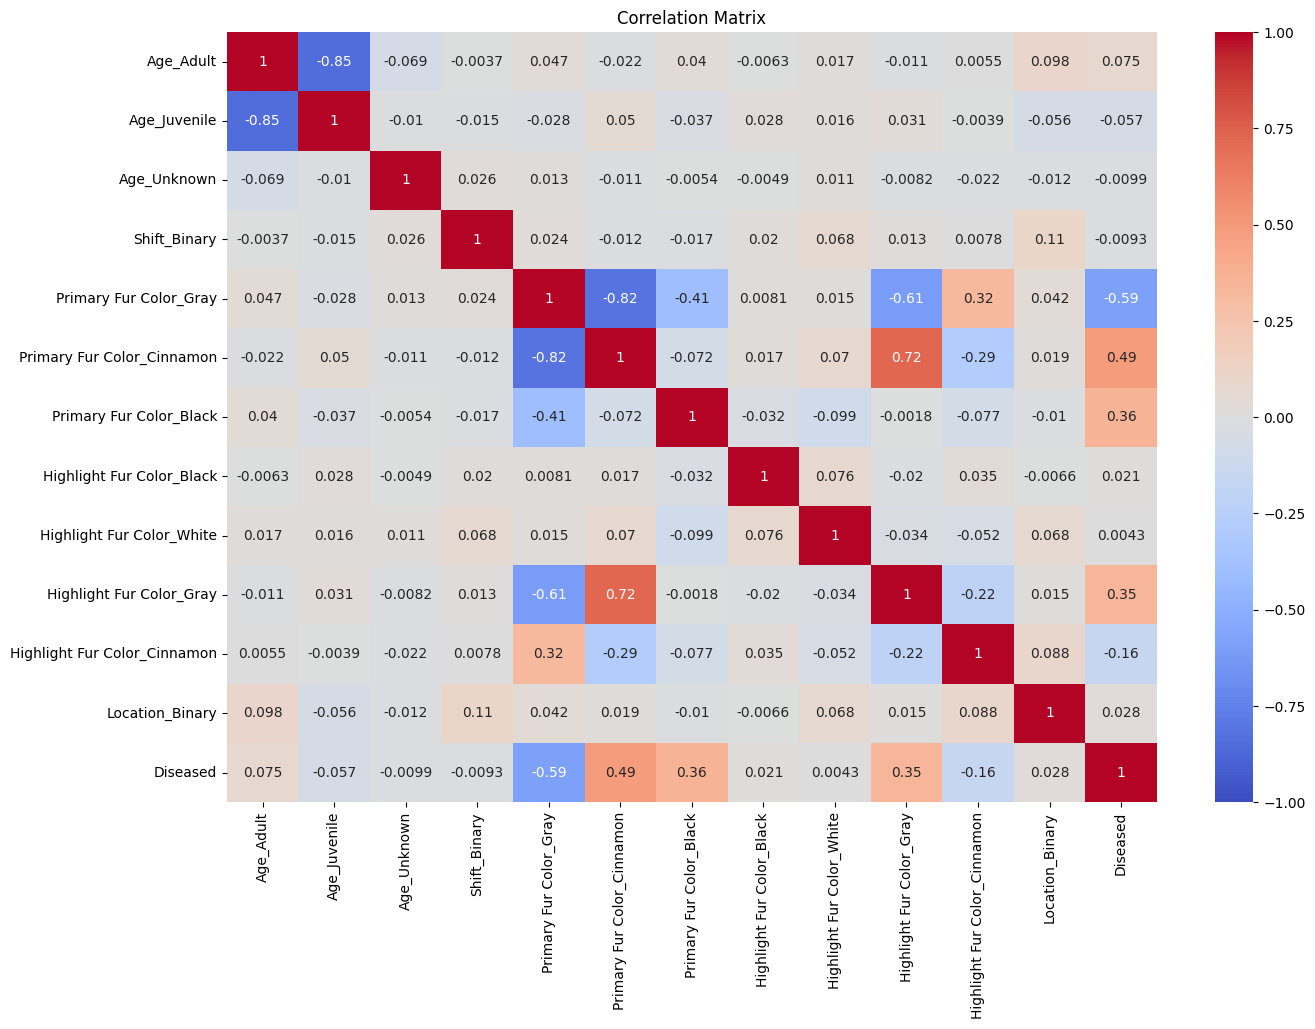

In [114]:
plt.figure(figsize=(15, 10))

sns.heatmap(train[['Age_Adult', 'Age_Juvenile', 'Age_Unknown', 'Shift_Binary', 'Primary Fur Color_Gray', 'Primary Fur Color_Cinnamon', 'Primary Fur Color_Black', 'Highlight Fur Color_Black', 'Highlight Fur Color_White', 'Highlight Fur Color_Gray', 'Highlight Fur Color_Cinnamon', 'Location_Binary', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

Seeing that the primary colors have better correlation than age and correlation, I think it is better to just use primary colors.